# Create the figure from ROMS output using 1-daily output

imports

In [2]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib as mpl
import seaborn as sb
sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# others
import scipy as sc
from scipy.interpolate import interp1d

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("netCDF4 version =", nc.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sc.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg/2hets_nob1p0"
os.chdir(wrkdir)
os.getcwd()

#ProgressBar().register()


python version = 3.10.
numpy version = 1.26.4
xarray version = 2024.3.0
netCDF4 version = 1.6.5
dask version = 2023.3.0
pandas version = 2.2.2
scipy version = 1.14.1
seaborn version = 0.12.2
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


'/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg/2hets_nob1p0'

# Load model output

In [3]:
data = xr.open_mfdataset(['avg_2050_D000-D090.nc','avg_2050_D091-D180.nc','avg_2050_D181-D270.nc', 'avg_2050_D271-D365.nc'])
#data = xr.open_dataset('avg_2051_daily.nc')

z_rho = data['z_r']
Hz = data['Hz']
o2 = data.O2
no2 = data.NO2
nitrox = data.NITROX
ammox = data.AMMOX
nob = data.NOB
aoa = data.AOA

data

<xarray.Dataset> Size: 895GB
Dimensions:         (time: 365, eta_rho: 502, xi_rho: 402, xi_u: 401,
                     eta_v: 501, s_rho: 42, s_w: 43)
Coordinates:
    lon_rho         (eta_rho, xi_rho) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
  * time            (time) float64 3kB 1.578e+09 1.578e+09 ... 1.609e+09
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, s_rho, s_w
Data variables: (12/84)
    spherical       (time) |S1 365B b'T' b'T' b'T' b'T' ... b'T' b'T' b'T' b'T'
    h               (time, eta_rho, xi_rho) float32 295MB dask.array<chunksize=(90, 502, 402), meta=np.ndarray>
    f               (time, eta_rho, xi_rho) float32 295MB dask.array<chunksize=(90, 502, 402), meta=np.ndarray>
    pm              (time, eta_rho, xi_rho) float32 295MB dask.array<chunksize=(90, 502, 402), meta=np.ndarray>
    pn              (time, eta_rho, xi_rho) float32 295MB dask.array<chunksize=(90, 502, 402), meta=np.ndarray>
    angle           (time, eta_rho, xi_rho) float32 295MB dask.array<chunksize=(90, 502, 402), meta=np.ndarray>
    ...              ...
    NIOana          (time, s_rho, eta_rho, xi_rho) float32 12GB dask.array<chunksize=(1, 14, 168, 134), meta=np.ndarray>
    NOBfmu          (time, s_rho, eta_rho, xi_rho) float32 12GB dask.array<chunksize=(1, 14, 168, 134), meta=np.ndarray>
    DENITRIF5       (time, s_rho, eta_rho, xi_rho) float32 12GB dask.array<chunksize=(1, 14, 168, 134), meta=np.ndarray>
    z_r             (time, s_rho, eta_rho, xi_rho) float32 12GB dask.array<chunksize=(1, 14, 168, 134), meta=np.ndarray>
    z_w             (time, s_w, eta_rho, xi_rho) float32 13GB dask.array<chunksize=(1, 15, 168, 134), meta=np.ndarray>
    Hz              (time, s_rho, eta_rho, xi_rho) float32 12GB dask.array<chunksize=(1, 14, 168, 134), meta=np.ndarray>
Attributes: (12/36)
    title:          peru_chile_0p1, 0.1 degree resolution
    type:           ROMS averages file
    grid_file:      /expanse/lustre/projects/ciw112/pbuchanan/GRID/peru_chile...
    init_file:      /expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile...
    ntimes:         9720
    ndtfast:        45
    ...             ...
    rdrg2:          0.0
    rdrg2_units:    nondimensional
    Zob:            0.0
    Zob_units:      m
    SRCS:           IOSRC : checkdims.F find_record.F insert_node.F ncdf_read...
    CPPS:           <cppdefs_UP.h> SOLVE3D UV_ADV UV_COR NONLIN_EOS SPLIT_EOS...

# Get Coordinates

In [4]:
fname = '/home/pbuchanan/peru_chile_0p1_files/peru_chile_0p1_grd.nc' 
data = xr.open_dataset(fname)
data = data.rename_dims({"eta_rho":"y_c", "xi_rho":"x_c"})
lon_rho = data.coords['lon_rho']
lat_rho = data.coords['lat_rho']


# Define a new dataset manually with its coordinates and the variables we want

In [6]:
chunky = {'time':1, 'z_c':1, 'y_c':502, 'x_c':402}
ds = xr.Dataset(
    {"lon_rho": ( ("y_c", "x_c"), lon_rho.values),
     "lat_rho": ( ("y_c", "x_c"), lat_rho.values)},
    coords={"x_c": (["x_c"], np.arange(1,403)),
            "y_c": (["y_c"], np.arange(1,503)),
            "z_c": (["z_c"], np.arange(1,43)),
            "time":(["time"],np.arange(1,366))}).chunk(chunks=chunky)

ds

<xarray.Dataset> Size: 2MB
Dimensions:  (y_c: 502, x_c: 402, z_c: 42, time: 365)
Coordinates:
  * x_c      (x_c) int64 3kB 1 2 3 4 5 6 7 8 ... 395 396 397 398 399 400 401 402
  * y_c      (y_c) int64 4kB 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * z_c      (z_c) int64 336B 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    lon_rho  (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    lat_rho  (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>

In [7]:
### assign other variables to the dataset
ds = ds.assign({"z_rho": ( ("time", "z_c", "y_c", "x_c"), z_rho.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"Hz": ( ("time", "z_c", "y_c", "x_c"),  Hz.values)}).chunk(chunks=chunky)
print("Added Hz")
ds = ds.assign({"O2": ( ("time", "z_c", "y_c", "x_c"),  o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"NO2": ( ("time", "z_c", "y_c", "x_c"), no2.values)}).chunk(chunks=chunky)
print("Added NO2")
ds = ds.assign({"AOA": ( ("time", "z_c", "y_c", "x_c"), aoa.values)}).chunk(chunks=chunky)
print("Added AOA")
ds = ds.assign({"NOB": ( ("time", "z_c", "y_c", "x_c"), nob.values)}).chunk(chunks=chunky)
print("Added NOB")
ds = ds.assign({"NHx": ( ("time", "z_c", "y_c", "x_c"), ammox.values)}).chunk(chunks=chunky)
print("Added NHx")
ds = ds.assign({"NOx": ( ("time", "z_c", "y_c", "x_c"), nitrox.values)}).chunk(chunks=chunky)
print("Added NOx")

ds

Added z_rho
Added Hz
Added O2
Added NO2
Added AOA
Added NOB
Added NHx
Added NOx


<xarray.Dataset> Size: 99GB
Dimensions:  (y_c: 502, x_c: 402, z_c: 42, time: 365)
Coordinates:
  * x_c      (x_c) int64 3kB 1 2 3 4 5 6 7 8 ... 395 396 397 398 399 400 401 402
  * y_c      (y_c) int64 4kB 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * z_c      (z_c) int64 336B 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    lon_rho  (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    lat_rho  (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    z_rho    (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    Hz       (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    O2       (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    NO2      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    AOA      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    NOB      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    NHx      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    NOx      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>

/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983112/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


# Check the size of the arrays in Gb and their chunks in Mb

In [8]:
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)


Total size of array in Gb 98.99859516000001
Total size of chunk in Mb 272.846584


# Calculate the AMZ thickness

In [9]:
amz = ds["O2"].where(ds["O2"] < 1.0, other=0.0).chunk(chunks=chunky)
amz = amz.where(ds["O2"] >= 1.0, other=1.0).chunk(chunks=chunky)
amz_thick = amz * ds["Hz"]


# Select a depth slice for nitrite oxidation

In [10]:
ds["O2"] = ds["O2"].where(ds["O2"] > 0.0, other = 0.0)

slice_nox = ds["NOx"].where((ds["z_rho"] > -400).compute() & (ds["z_rho"] < -200).compute(), drop=True).max(dim="z_c")
slice_oxy = ds["O2"].where((ds["z_rho"] > -400).compute() & (ds["z_rho"] < -200).compute(), drop=True).mean(dim="z_c")
slice_oxs = ds["O2"].where((ds["z_rho"] > -400).compute() & (ds["z_rho"] < -200).compute(), drop=True).std(dim="z_c")

slice_oxs

<xarray.DataArray 'O2' (time: 365, y_c: 502, x_c: 398)> Size: 292MB
dask.array<_sqrt, shape=(365, 502, 398), dtype=float32, chunksize=(1, 502, 398), chunktype=numpy.ndarray>
Coordinates:
  * x_c      (x_c) int64 3kB 1 2 3 4 5 6 7 8 ... 391 392 393 394 395 396 397 398
  * y_c      (y_c) int64 4kB 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

# Select the data along a transect

In [11]:
longitude = 275
lon1 = longitude-0.5
lon2 = longitude+0.5

transect_o2 = ds["O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_o2s = ds["O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).std(dim="x_c")
transect_no2 = ds["NO2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_nhx = ds["NHx"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_nox = ds["NOx"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")

transect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
transect_z = ds["z_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")

### broadcast transect_y (lats) across the depth axis
transect_y = np.repeat(transect_y.values[np.newaxis,:], 42, axis=0) 

### correct for negative values
transect_o2 = transect_o2.where(transect_o2 > 0.0, other=0.0)
transect_no2 = transect_no2.where(transect_no2 > 0.0, other=0.0)


# save all the point within the horizontal region

In [13]:
lon1 = 264.5
lon2 = 278.5
lat1 = -12.5
lat2 = -3.5
dep1 = 0.0
dep2 = 1000.0

profile50_z = ds["z_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                             & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                             & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute().mean(dim=("x_c","y_c","time"))

allprofiles_z = ds["z_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                             & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                             & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()

allprofiles_o2 = ds["O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                        & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                        & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()

allprofiles_nox = ds["NOx"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                        & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                        & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()
    
allprofiles_nhx = ds["NHx"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                        & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                        & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()

allprofiles_nob = ds["NOB"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                        & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                        & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()

allprofiles_aoa = ds["AOA"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                        & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                        & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()

Ccell_nob = 3.98e-15 
Ccell_aoa = 1.15e-15
cells_per_mL_nob = 1e-3 * 12 / Ccell_nob * 1e-6
cells_per_mL_aoa = 1e-3 * 12 / Ccell_aoa * 1e-6

minbio = 1e-4

ds['NOB2AOA'] = (ds["NOB"].where(ds["NOB"] > minbio, other=minbio) * cells_per_mL_nob) / (ds["AOA"].where(ds["AOA"] > minbio, other=minbio) * cells_per_mL_aoa)
allprofiles_nob2aoa = ds["NOB2AOA"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute() \
                        & (ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute() \
                        & (-ds["z_rho"] > dep1).compute() & (-ds["z_rho"] < dep2).compute(), drop=True).compute()


#profiles_nob[ii,:] = profiles_nob[ii,:].where(profiles_nob[ii,:] > 0.0, other=1e-16)
#profiles_aoa[ii,:] = profiles_aoa[ii,:].where(profiles_aoa[ii,:] > 0.0, other=1e-16)
#profiles_nob2aoa[ii,:] = profiles_nob2aoa[ii,:].where(profiles_nob2aoa[ii,:] > 0.0, other=1e-16)


# Calculate the cells per mL of NOB and AOA

In [14]:
Ccell_nob = 3.98e-15 
Ccell_aoa = 1.15e-15
cells_per_mL_nob = 1e-3 * 12 / Ccell_nob * 1e-6
cells_per_mL_aoa = 1e-3 * 12 / Ccell_aoa * 1e-6

allprofiles_Caoa = allprofiles_aoa * cells_per_mL_aoa
allprofiles_Cnob = allprofiles_nob * cells_per_mL_nob



# set the parameters for the figure

In [15]:
contcol = 'k' 
colmap1 = lighten(cmo.amp, 0.8)
#colmap1 = mpl.cm.RdPu

## for AMZ thickness
levs1 = np.concatenate((np.arange(0,50,5), np.arange(50,200,10), np.arange(200,501,50)))
levs1 = np.arange(0,501,20)
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [10, 100, 300, 500]
contl1 = [0.5, 0.5, 0.5, 0.5]

colmap2 = lighten(cmo.oxy, 0.8)
#colmap2 = mpl.cm.RdPu
levs2 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm2 = mpl.colors.BoundaryNorm(levs2, colmap2.N)
conts2 = [1, 10, 20, 50]
contl2 = [0.5, 0.5, 0.5, 0.5]

### for NO2
#colmap3 = lighten(cmo.amp, 0.8)
#levs3 = np.concatenate((np.arange(0,10,1), np.arange(10,51,5)))*0.1
#norm3 = mpl.colors.BoundaryNorm(levs3, colmap3.N)
#conts3 = [0.01, 0.10, 0.20, 0.50]
#contl3 = [0.5, 0.5, 0.5, 0.5]

### for NH3 oxidation
colmap3 = lighten(cmo.amp, 0.8)
#colmap3 = mpl.cm.RdPu
levs3 = np.concatenate((np.arange(0,10,1), np.arange(10,100,5),np.arange(100,301,20)))
norm3 = mpl.colors.BoundaryNorm(levs3, colmap3.N)
conts3 = [1, 10, 100, 500]
contl3 = [0.5, 0.5, 0.5, 0.5]

### for NO2 oxidation
colmap4 = lighten(cmo.amp, 0.8)
#colmap4 = mpl.cm.RdPu
levs4 = np.concatenate((np.arange(0,10,1), np.arange(10,100,5),np.arange(100,301,20)))
norm4 = mpl.colors.BoundaryNorm(levs4, colmap4.N)
conts4 = [1, 10, 100, 500]
contl4 = [0.5, 0.5, 0.5, 0.5]


fstic = 13
fslab = 15

proj = ccrs.PlateCarree()


# Get observations to add to the figure

In [17]:
#%% load the nitrification rate data

wrkdir = "/home/pbuchanan/analysis_nox"
os.chdir(wrkdir)

nhx = pd.read_excel('nitrification_database.xlsx', sheet_name="volumetric ammonia oxidation")
nox = pd.read_excel('nitrification_database.xlsx', sheet_name="volumetric nitrite oxidation")

#%% clean the dataset (drop the rows without NH4 oxidation rate data, O2 data, etc,)
columns = nhx.columns

### remove unnecessary columns
nhx = nhx.drop([columns[7], columns[8], columns[9], columns[10], columns[11], columns[12], columns[13], columns[14], columns[15]], axis=1)
nox = nox.drop([columns[7], columns[8], columns[9], columns[10], columns[11], columns[12], columns[13], columns[14], columns[15]], axis=1)

### convert all string dates to datetime
nhx_unique_dates = nhx['Date '].unique()
nhx_string_dates = [item for item in nhx_unique_dates if isinstance(item, str)]
print(nhx_string_dates)
nhx.loc[nhx['Date '] == '2011 January', 'Date '] = pd.to_datetime("2011-04-15")
nhx.loc[nhx['Date '] == '2012 January', 'Date '] = pd.to_datetime("2012-01-15")
nhx.loc[nhx['Date '] == '2010 April', 'Date '] = pd.to_datetime("2010-04-15")
nhx.loc[nhx['Date '] == '2011 April', 'Date '] = pd.to_datetime("2011-04-15")
nhx.loc[nhx['Date '] == '2010 August', 'Date '] = pd.to_datetime("2010-08-15")
nhx.loc[nhx['Date '] == '2011 August', 'Date '] = pd.to_datetime("2011-08-15")
nhx.loc[nhx['Date '] == '1993 March to May', 'Date '] = pd.to_datetime("1993-04-01")
nhx.loc[nhx['Date '] == '2005 October', 'Date '] = pd.to_datetime("2005-10-15")
nhx.loc[nhx['Date '] == '2017 June', 'Date '] = pd.to_datetime("2017-06-15")
nhx.loc[nhx['Date '] == '2008 May/June', 'Date '] = pd.to_datetime("2008-06-01")
nhx.loc[nhx['Date '] == '2008 Dec-2009 Jan', 'Date '] = pd.to_datetime("2009-01-01")
nhx.loc[nhx['Date '] == '2009 Feb', 'Date '] = pd.to_datetime("2009-02-15")
nhx.loc[nhx['Date '] == '2005 April', 'Date '] = pd.to_datetime("2005-04-15")
nhx.loc[nhx['Date '] == '2015 August', 'Date '] = pd.to_datetime("2015-08-15")
nhx.loc[nhx['Date '] == '1995 Jan', 'Date '] = pd.to_datetime("1995-01-15")
nhx.loc[nhx['Date '] == '2012 March', 'Date '] = pd.to_datetime("2012-03-15")
nhx.loc[nhx['Date '] == '2013 June', 'Date '] = pd.to_datetime("2013-06-15")
nhx.loc[nhx['Date '] == '1994 Nov', 'Date '] = pd.to_datetime("1994-11-15")
nhx.loc[nhx['Date '] == '2007 July', 'Date '] = pd.to_datetime("2007-07-15")
nhx.loc[nhx['Date '] == '2009 October', 'Date '] = pd.to_datetime("2009-10-15")
nhx.loc[nhx['Date '] == '2017 July', 'Date '] = pd.to_datetime("2017-07-15")
nhx.loc[nhx['Date '] == '2000 May', 'Date '] = pd.to_datetime("2000-05-15")
nhx.loc[nhx['Date '] == '1982 June', 'Date '] = pd.to_datetime("1982-06-15")
nhx.loc[nhx['Date '] == '1982 Nov', 'Date '] = pd.to_datetime("1982-11-15")
nhx.loc[nhx['Date '] == '1983 May', 'Date '] = pd.to_datetime("1983-05-15")
nhx.loc[nhx['Date '] == '1983 Nov', 'Date '] = pd.to_datetime("1983-11-15")
nhx.loc[nhx['Date '] == '1985 Feb', 'Date '] = pd.to_datetime("1985-02-15")
nhx.loc[nhx['Date '] == '2016 May', 'Date '] = pd.to_datetime("2016-05-15")
nhx.loc[nhx['Date '] == '2015 April', 'Date '] = pd.to_datetime("2015-04-15")
#nhx.loc[nhx['Date '] == '', 'Date '] = pd.to_datetime("2015-04-01")

nox_unique_dates = nox['Date '].unique()
nox_string_dates = [item for item in nox_unique_dates if isinstance(item, str)]
print(nox_string_dates)
nox.loc[nox['Date '] == '1993 March to May', 'Date '] = pd.to_datetime("1993-04-01")
nox.loc[nox['Date '] == '2008 Dec-2009 Jan', 'Date '] = pd.to_datetime("2009-01-01")
nox.loc[nox['Date '] == '2009 Feb', 'Date '] = pd.to_datetime("2009-02-15")
nox.loc[nox['Date '] == '2012 March', 'Date '] = pd.to_datetime("2012-03-15")
nox.loc[nox['Date '] == '2013 June', 'Date '] = pd.to_datetime("2013-06-15")
nox.loc[nox['Date '] == '1985 Feb', 'Date '] = pd.to_datetime("1985-02-15")
nox.loc[nox['Date '] == '2016 May', 'Date '] = pd.to_datetime("2016-05-15")
nox.loc[nox['Date '] == '2015 April', 'Date '] = pd.to_datetime("2015-04-15")

### allocate studies to a unique ID based on identifying date, longitude, latitude and depth
nhx['unique_ID'] = nhx['Date '].apply(lambda x: int(x.timestamp())) + nhx['Latitude '] + nhx['Longitude'] + nhx['Depth (m)']
nox['unique_ID'] = nox['Date '].apply(lambda x: int(x.timestamp())) + nox['Latitude '] + nox['Longitude'] + nox['Depth (m)']


### remove rows without rate data
print(columns[5])
todrop1 = nhx[nhx[columns[5]]=='NM']
todrop2 = nhx[nhx[columns[5]]=='BDL']
nhx = nhx.drop(todrop1.index)
nhx = nhx.drop(todrop2.index)

todrop1 = nox[nox[columns[5]]=='NM']
todrop2 = nox[nox[columns[5]]=='BDL']
nox = nox.drop(todrop1.index)
nox = nox.drop(todrop2.index)


### make errors nan if not measured
tomakeNAN = nhx[nhx[columns[6]]=='NM']
nhx.loc[tomakeNAN.index, columns[6]] = np.nan


### remove rows without oxygen data
print(columns[-1])
todrop3 = nhx[nhx[columns[-1]]=='NM']
nhx = nhx.drop(todrop3.index)

todrop3 = nox[nox[columns[-1]]=='NM']
nox = nox.drop(todrop3.index)


### make BDL oxygen data equal to 0.0
tomake0 = nhx[nhx[columns[-1]]=='BDL']
nhx.loc[tomake0.index, columns[-1]] = 0.0

tomake0 = nox[nox[columns[-1]]=='BDL']
nox.loc[tomake0.index, columns[-1]] = 0.0


### make O2 and rate data numeric
nhx[columns[-1]] = pd.to_numeric(nhx[columns[-1]])
nhx[columns[5]] = pd.to_numeric(nhx[columns[5]])
nhx[columns[6]] = pd.to_numeric(nhx[columns[6]])

nox[columns[-1]] = pd.to_numeric(nox[columns[-1]])
nox[columns[5]] = pd.to_numeric(nox[columns[5]])
nox[columns[6]] = pd.to_numeric(nox[columns[6]])


print("Number of Ammonia oxidation rate data = ", len(nhx))
print("Number of Nitrite oxidation rate data = ", len(nox))


#%% combine the dataframes on the unique_ID column
merged_rates = pd.merge(nhx, nox, on='unique_ID', how='outer') 

### rename the rate column for each data frame to be distinct
merged_rates.rename(columns={columns[5]+"_x":"Ammonia oxidation", columns[5]+"_y":"Nitrite oxidation"}, inplace=True)
merged_rates.rename(columns={columns[6]+"_x":"Ammonia oxidation (standard deviation)", columns[6]+"_y":"Nitrite oxidation (standard deviation)"}, inplace=True)

### combine longitude, latitude, depth and oxygen data into single columns and drop the others
cols = merged_rates.columns
merged_rates['Longitude'] = merged_rates['Longitude_x'].combine_first(merged_rates['Longitude_y'])
merged_rates['Latitude'] = merged_rates['Latitude _x'].combine_first(merged_rates['Latitude _y'])
merged_rates['Depth'] = merged_rates['Depth (m)_x'].combine_first(merged_rates['Depth (m)_y'])
merged_rates['Oxygen'] = merged_rates[cols[7]].combine_first(merged_rates[cols[-1]])
merged_rates['Date'] = merged_rates['Date _x'].combine_first(merged_rates['Date _y'])

merged_rates.drop(columns=[cols[1], cols[2], cols[3], cols[4], cols[7], cols[10], cols[11], cols[12], cols[13], cols[-1]], inplace=True)

### bin the O2 data
o2_bins = np.concatenate( (np.arange(0,1,0.1), np.arange(1,10,1), np.arange(10,100,10), np.arange(100,401,20)) )
o2_labs = o2_bins[0:-1] + np.diff(o2_bins)*0.5

merged_rates['O2bins'] = pd.to_numeric(pd.cut(merged_rates['Oxygen'], bins=o2_bins, labels=o2_labs))


### drop data where we don't have oxygen data
todrop = merged_rates[np.isnan(merged_rates['Oxygen'])]
merged_rates = merged_rates.drop(todrop.index)



['2011 January', '2012 January', '2010 April', '2011 April', '2010 August', '2011 August', '1993 March to May', '2005 October', '2017 June', '2008 May/June', '2008 Dec-2009 Jan', '2009 Feb', '2005 April', '2015 August', '1995 Jan', '2012 March', '2013 June', '1994 Nov', '2007 July', '2009 October', '2017 July', '2000 May', '1982 June', '1982 Nov', '1983 May', '1983 Nov', '1985 Feb', '2016 May', '2015 April']
['1993 March to May', '2008 Dec-2009 Jan', '2009 Feb', '2012 March', '2013 June', '1985 Feb', '2016 May', '2015 April']
Rate (nmol N L-1 d-1)
O2 (μM)
Number of Ammonia oxidation rate data =  2045
Number of Nitrite oxidation rate data =  874


## tell me what studies the rate data come from

In [18]:
cols = merged_rates.columns
todrop1 = merged_rates[np.isnan(merged_rates[cols[1]])]
merged_rates = merged_rates.drop(todrop1.index) 
todrop2 = merged_rates[np.isnan(merged_rates[cols[5]])]
merged_rates = merged_rates.drop(todrop2.index)

print(merged_rates['Data source_x'].unique())
print(merged_rates['Data source_y'].unique())


[nan 'Clark et al., 2008. L&O.' 'Data shown in Figures 5 and 6 '
 'detection limit not reported' 'Beman et al., 2012. L&O'
 'data shown in Figures 3, 4 and 5' 'Santoro et al., 2021. GBC.'
 'detection limit of ammonium: 0.01 uM'
 'detection limit of nitrite: 0.1 uM' 'Peng et al., 2015. GBC.'
 'detection limit: 0.01-0.12 nM d-1 in anoxic water'
 'detection limit: 0.001-0.034 nM d-1 in other water'
 'Bristow et al., 2015. L&O.' 'Data shown in Figure 5'
 'Peng et al., 2016. JGR: Oceans'
 'detection limit: 0.01-0.1 nM d-1 in anoxic water'
 'Data shown in Figures 2, 3 and 4'
 'detection limit: 0.003-0.065 nM d-1 in other water'
 'Ganesh et al., 2015. ISME J.' 'Data shown in Figure 1'
 'Data shown in Figures 3 and 4' 'detection limit: 0.01-0.5 nM d-1 '
 'Kitzinger et al., 2020. Nature Comms'
 'data shown in Figure 1 and Supplementary Data 1'
 'Beman et al., 2021. Nature Comms']
[nan 'Clark et al., 2008. LO.' 'Data shown in Figures 5 and 6 '
 'Beman et al., 2013. ISME J' 'data shown in Figures

In [19]:
#%% load the AOA and NOB abundance data

wrkdir = "/home/pbuchanan/analysis_nox"
os.chdir(wrkdir)

aoa = pd.read_excel('nitrification_database.xlsx', sheet_name="ammonia oxidizer")
nob = pd.read_excel('nitrification_database.xlsx', sheet_name="NOB")


### remove unnecessary columns
columns = aoa.columns
aoa = aoa.drop([columns[5], columns[6], columns[9], columns[10], columns[11], columns[12], \
                columns[13], columns[14], columns[15], columns[16], columns[17], columns[18], \
                columns[19], columns[20], columns[21], columns[22]], axis=1)
columns = nob.columns
nob = nob.drop([columns[7], columns[8], columns[9], columns[10], columns[11], columns[12], \
                columns[13], columns[14], columns[15], columns[16], columns[17], columns[18], \
                columns[19]], axis=1)

### convert all string dates to datetime
aoa_unique_dates = aoa['Date '].unique()
aoa_string_dates = [item for item in aoa_unique_dates if isinstance(item, str)]
print(aoa_string_dates)
aoa.loc[aoa['Date '] == '2002 September', 'Date '] = pd.to_datetime("2002-09-15")
aoa.loc[aoa['Date '] == '2006 Nov-Dec', 'Date '] = pd.to_datetime("2006-12-01")
aoa.loc[aoa['Date '] == '2017 June', 'Date '] = pd.to_datetime("2017-06-15")
aoa.loc[aoa['Date '] == '2013 August', 'Date '] = pd.to_datetime("2013-08-15")
aoa.loc[aoa['Date '] == '2008 Dec-2009 Jan', 'Date '] = pd.to_datetime("2009-01-01")
aoa.loc[aoa['Date '] == '2007 September', 'Date '] = pd.to_datetime("2007-09-15")
aoa.loc[aoa['Date '] == '2005 October', 'Date '] = pd.to_datetime("2005-10-15")
aoa.loc[aoa['Date '] == '2012 March', 'Date '] = pd.to_datetime("2012-03-15")
aoa.loc[aoa['Date '] == '2013 June', 'Date '] = pd.to_datetime("2013-06-15")
aoa.loc[aoa['Date '] == '2007 July', 'Date '] = pd.to_datetime("2007-07-15")
aoa.loc[aoa['Date '] == '2009 October', 'Date '] = pd.to_datetime("2009-10-15")
aoa.loc[aoa['Date '] == '2014 June - August', 'Date '] = pd.to_datetime("2014-07-15")
aoa.loc[aoa['Date '] == '2003 May-June', 'Date '] = pd.to_datetime("2003-06-01")
aoa.loc[aoa['Date '] == '2016 May', 'Date '] = pd.to_datetime("2016-05-15")
aoa.loc[aoa['Date '] == '2015 April', 'Date '] = pd.to_datetime("2015-04-15")

nob_unique_dates = nob['Date '].unique()
nob_string_dates = [item for item in nob_unique_dates if isinstance(item, str)]
print(nob_string_dates)
nob.loc[nob['Date '] == '2007 July', 'Date '] = pd.to_datetime("2007-07-15")
nob.loc[nob['Date '] == '2016 May', 'Date '] = pd.to_datetime("2016-05-15")
nob.loc[nob['Date '] == '2015 April', 'Date '] = pd.to_datetime("2015-04-15")

### allocate studies to a unique ID based on identifying date, longitude, latitude and depth
aoa['unique_ID'] = aoa['Date '].apply(lambda x: int(x.timestamp())) + aoa['Latitude '] + aoa['Longitude'] + aoa['Depth (m)']
nob['unique_ID'] = nob['Date '].apply(lambda x: int(x.timestamp())) + nob['Latitude '] + nob['Longitude'] + nob['Depth (m)']

aoacols = aoa.columns    
nobcols = nob.columns    

### remove rows without rate data
print(aoacols[6])
todrop1 = aoa[aoa[aoacols[6]]=='NM']
todrop2 = aoa[aoa[aoacols[6]]=='BDL']
aoa = aoa.drop(todrop1.index)
aoa = aoa.drop(todrop2.index)

print(nobcols[6])
todrop1 = nob[nob[nobcols[6]]=='NM']
todrop2 = nob[nob[nobcols[6]]=='BDL']
nob = nob.drop(todrop1.index)
nob = nob.drop(todrop2.index)


### make the gene copy numbers == 0.0 if BDL
print(aoacols[5])
tomake0 = aoa[aoa[aoacols[5]]=='BDL']
aoa.loc[tomake0.index, aoacols[5]] = 0.0
tomake0 = aoa[aoa[aoacols[5]]=='NM']
aoa.loc[tomake0.index, aoacols[5]] = 0.0
print(aoacols[6])
tomake0 = aoa[aoa[aoacols[6]]=='BDL']
aoa.loc[tomake0.index, aoacols[6]] = 0.0

print(nobcols[5])
tomake0 = nob[nob[nobcols[5]]=='BDL']
nob.loc[tomake0.index, nobcols[5]] = 0.0


### remove rows without oxygen data
print(aoacols[-2])
todrop3 = aoa[aoa[aoacols[-2]]=='NM']
aoa = aoa.drop(todrop3.index)
tomake0 = aoa[aoa[aoacols[-2]]=='BDL']
aoa.loc[tomake0.index, aoacols[-2]] = 0.0

print(nobcols[-2])
todrop3 = nob[nob[nobcols[-2]]=='NM']
nob = nob.drop(todrop3.index)


### make rRNA gene numbers and O2 numerical
aoa[aoacols[5]] = pd.to_numeric(aoa[aoacols[5]])
aoa[aoacols[6]] = pd.to_numeric(aoa[aoacols[6]])
aoa[aoacols[7]] = pd.to_numeric(aoa[aoacols[7]])

nob[nobcols[5]] = pd.to_numeric(nob[nobcols[5]])
nob[nobcols[6]] = pd.to_numeric(nob[nobcols[6]])
nob[nobcols[7]] = pd.to_numeric(nob[nobcols[7]])


print("Number of Ammonia oxidation rate data = ", aoa.count())
print("Number of Nitrite oxidation rate data = ", nob.count())


### combine the dataframes on the unique_ID column
merged_genes = pd.merge(aoa, nob, on='unique_ID', how='outer') 

### combine longitude, latitude, depth and oxygen data into single columns and drop the others
cols = merged_genes.columns
merged_genes['Longitude'] = merged_genes['Longitude_x'].combine_first(merged_genes['Longitude_y'])
merged_genes['Latitude'] = merged_genes['Latitude _x'].combine_first(merged_genes['Latitude _y'])
merged_genes['Depth'] = merged_genes['Depth (m)_x'].combine_first(merged_genes['Depth (m)_y'])
merged_genes['Oxygen'] = merged_genes[cols[7]].combine_first(merged_genes[cols[-1]])
merged_genes['Date'] = merged_genes['Date _x'].combine_first(merged_genes['Date _y'])

merged_genes.drop(columns=[cols[1], cols[2], cols[3], cols[4], cols[7], cols[10], cols[11], cols[12], cols[13], cols[-1]], inplace=True)

### bin the O2 data
o2_bins = np.concatenate( (np.arange(0,1,0.1), np.arange(1,10,1), np.arange(10,100,10), np.arange(100,401,20)) )
o2_labs = o2_bins[0:-1] + np.diff(o2_bins)*0.5

merged_genes['O2bins'] = pd.to_numeric(pd.cut(merged_genes['Oxygen'], bins=o2_bins, labels=o2_labs))


### drop data where we don't have oxygen data
todrop = merged_genes[np.isnan(merged_genes['Oxygen'])]
merged_genes = merged_genes.drop(todrop.index)


['2002 September', '2006 Nov-Dec', '2017 June', '2013 August', '2008 Dec-2009 Jan', '2007 September', '2005 October', '2012 March', '2013 June', '2007 July', '2009 October', '2014 June - August', '2003 May-June', '2016 May', '2015 April']
['2007 July', '2016 May', '2015 April']
Thaumarchaeota 16S rRNA (copies L-1)
Nitrospina 16S rRNA gene (copies L-1)
total AOA (copies L-1)
Thaumarchaeota 16S rRNA (copies L-1)
Nitrospira 16S rRNA gene (copies L-1)
O2 (μM)
O2 (μM)
Number of Ammonia oxidation rate data =  Data source                               58
Date                                    2241
Latitude                                2241
Longitude                               2241
Depth (m)                               2239
total AOA (copies L-1)                  1952
Thaumarchaeota 16S rRNA (copies L-1)    1131
O2 (μM)                                 1259
unique_ID                               2239
dtype: int64
Number of Nitrite oxidation rate data =  Data source                     

## tell me what studies the gene data come from

In [20]:
cols = merged_genes.columns
todrop1 = merged_genes[np.isnan(merged_genes[cols[2]])]
merged_genes = merged_genes.drop(todrop1.index) 
todrop2 = merged_genes[np.isnan(merged_genes[cols[6]])]
merged_genes = merged_genes.drop(todrop2.index)

print(merged_genes['Data source_x'].unique())
print(merged_genes['Data source_y'].unique())


['Beman et al., 2012. L&O' nan 'Damashek et al., 2018. L&O.'
 'Data shown in Figure 4 and Supplemetary Table']
['Beman et al., 2013. ISME J' nan 'data shown in Figures 2 and 3'
 'Damashek et al., 2018. L&O.'
 'Data shown in Figure 4 and Supplemetary Table'
 'BDL: below detection limt']


## previous observational datasets

In [18]:
wrkdir = "/home/pbuchanan/analysis_nox"
os.chdir(wrkdir)


ctd = pd.read_table('Santoro2021_ctd.txt', delimiter='\t')
nut = pd.read_table('Santoro2021_nh4no2data.txt', delimiter='\t')
nit = pd.read_excel('Santoro2021_rates.xlsx')

#print(ctd.columns)
#print(ctd['latitude'].unique())
#print(ctd['longitude'].unique())

### round all latitudes and longitudes to closest 1 degree
ctd['latitude'] = ctd['latitude'].round()
ctd['longitude'] = ctd['longitude'].round()
nut['Longitude'] = nut['Longitude'].round()
nit['lat'] = nit['lat'].round()
nit['lon'] = nit['lon'].round()

### remove rows with bad data
ctd[ctd['sbeox0']<0] == np.nan
ctd[ctd['sbeox0']>300] == np.nan
ctd = ctd.dropna()
nit[nit==-999] = np.nan
nit = nit.dropna(subset=['NO2ox'])

print(nit)

### bin data onto distinct depth levels and average measurements made across the SETP ODZ

### OXYGEN
### define the common depth bins and levels
dep_bins = np.arange(0,1501,5)  # every 5 metres
dep_bins[0] = -1
dep_levs = np.arange(2.5, 1501, 5)
### create new column with depth bin information
ctd['dep_bins'] = pd.cut(ctd['dep'], bins=dep_bins, labels=dep_levs)
ctd['dep_bins'] = ctd['dep_bins'].astype(float)
### get min, mean and max of NO2
ctd_bins = ctd.groupby('dep_bins').agg({'sbeox0': ['mean', 'min', 'max']})
### site 7
ctd_7 = ctd[(ctd['latitude']==-10) & (ctd['longitude']==-100)]

### NUTRIENTS
### define the common depth bins and levels
dep_bins = np.arange(0,1501,25)  # every 25 metres
dep_bins[0] = -1
dep_levs = np.arange(12.5, 1501, 25)
### create new column with depth bin information
nut['dep_bins'] = pd.cut(nut['Depth'], bins=dep_bins, labels=dep_levs)
nut['dep_bins'] = nut['dep_bins'].astype(float)
### get min, mean and max of NO2
nut_bins = nut.groupby('dep_bins').agg({'NO2': ['mean', 'min', 'max']})
nut_7 = nut[(nut['Latitude']==-10) & (nut['Longitude']==-100)]


#%% get observations from Babbin (ETNP and ETSP)
bab = pd.read_excel('Babbin2020.xlsx')


#%% collect the measured NOB:AOA
bem_cel = pd.read_excel("nxramoA.xlsx")
# assume 4 copies of Nxr per NOB cell
bem_cel['nxr/amoA'] = bem_cel['nxr/amoA']*0.50
# select inside and outside of OMZ
bem_oxy = bem_cel['nxr/amoA'][bem_cel['OMZ?']==0]
bem_omz = bem_cel['nxr/amoA'][bem_cel['OMZ?']==1]


     NH4ox  NH4ox_err   NO2ox  NO2ox_err  NO3red  Depth (m)   lat   lon  \
0     0.02       0.00    1.66       0.86     NaN         60 -20.0 -80.0   
1     0.27       0.14    0.57       0.23     NaN         80 -20.0 -80.0   
2     1.40       0.40    3.64       0.62     NaN        120 -20.0 -80.0   
3     0.88       0.62    8.40       0.36     NaN        235 -20.0 -80.0   
4     0.00       0.00    0.75       0.67     NaN         80 -20.0 -90.0   
..     ...        ...     ...        ...     ...        ...   ...   ...   
103  33.90       0.68   52.00       1.40     NaN         80 -15.0 -82.0   
104  19.71      20.82   64.70       7.50     NaN        100 -15.0 -82.0   
105  21.86      21.45   65.30       8.70     NaN        100 -15.0 -82.0   
106   0.17       0.74  126.30      44.60     NaN        400 -15.0 -82.0   
107   0.25       0.34   12.80     159.50     NaN        400 -15.0 -82.0   

     month  year  site location  
0        2  2010     1       ml  
1        2  2010     1       ml

# make figure

In [21]:
slice_nox.isel(time=30)
np.shape(ds['lon_rho'].values[:,2:-2])
np.shape(lon_rho.values[:,2:-2])

slice_oxyvar = slice_oxs / slice_oxy
slice_oxyvar = slice_oxyvar.where(slice_oxyvar > 0.0, other=0.0)


Number of profiles in the box to randomly sample from = 5972130
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


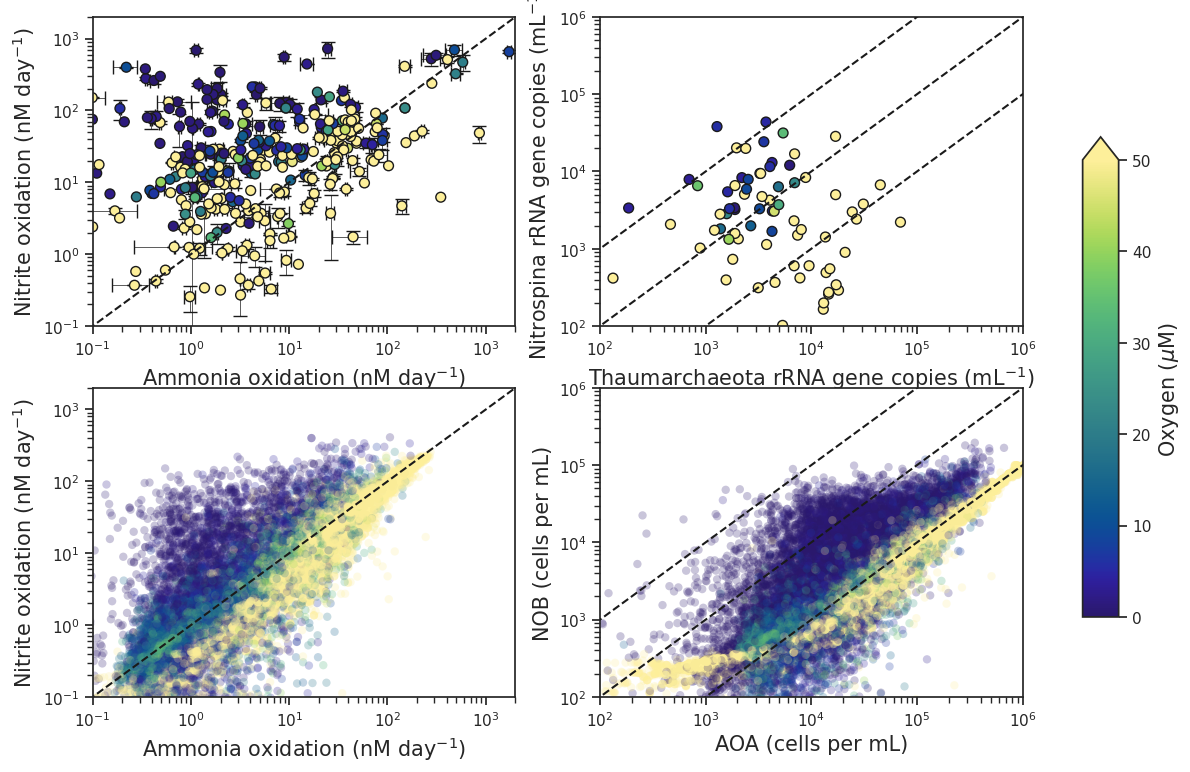

In [23]:
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2)


colmap = cmo.haline
#colmap = cmo.oxy
vmax = 50.0
vmin = 0.0

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])


ax1.errorbar(merged_rates['Ammonia oxidation'], merged_rates['Nitrite oxidation'], \
             xerr=merged_rates['Ammonia oxidation (standard deviation)'], yerr=merged_rates['Nitrite oxidation (standard deviation)'], \
             fmt='o', capsize=5, ms=0.1, ecolor='k', linewidth=0.5, zorder=1)
ax1.scatter(merged_rates['Ammonia oxidation'], merged_rates['Nitrite oxidation'], c=merged_rates['Oxygen'], \
            marker='o', s=50, cmap=colmap, vmin=vmin, vmax=vmax, zorder=2, alpha=1.0, edgecolor='k')

cols = merged_genes.columns
p2 = ax2.scatter(merged_genes[cols[2]]*1e-3, merged_genes[cols[6]]*1e-3, c=merged_genes['Oxygen'], \
                 marker='o', s=50, cmap=colmap, vmin=vmin, vmax=vmax, zorder=2, alpha=1.0, edgecolor='k')


stacked_z = allprofiles_z.stack(stacked_dim=['time','y_c','x_c'])
stacked_o2 = allprofiles_o2.stack(stacked_dim=['time','y_c','x_c'])
stacked_nox = allprofiles_nox.stack(stacked_dim=['time','y_c','x_c'])
stacked_nhx = allprofiles_nhx.stack(stacked_dim=['time','y_c','x_c'])
stacked_aoa = allprofiles_Caoa.stack(stacked_dim=['time','y_c','x_c'])
stacked_nob = allprofiles_Cnob.stack(stacked_dim=['time','y_c','x_c'])
stacked_nob2aoa = allprofiles_nob2aoa.stack(stacked_dim=['time','y_c','x_c'])

### create a random sampling of 10,000 profile from our array
size_of_array = len(stacked_z.coords['stacked_dim'])
print("Number of profiles in the box to randomly sample from =", size_of_array)
random_integers = np.random.randint(0, size_of_array, size=2000)

for ii,prof in enumerate(random_integers):
    if ii%100==0:
        print(ii)
    p3 = ax3.scatter(stacked_nhx.isel(stacked_dim=prof)*86400*1e3, stacked_nox.isel(stacked_dim=prof)*86400*1e3, c=stacked_o2.isel(stacked_dim=prof), \
                     cmap=colmap, edgecolor='none', vmin=vmin, vmax=vmax, alpha=0.25)
    p4 = ax4.scatter(stacked_aoa.isel(stacked_dim=prof), stacked_nob.isel(stacked_dim=prof), c=stacked_o2.isel(stacked_dim=prof), \
                     cmap=colmap, edgecolor='none', vmin=vmin, vmax=vmax, alpha=0.25)
    ### by depth instead?
    #p3 = ax3.scatter(stacked_nhx.isel(stacked_dim=prof)*86400*1e3, stacked_nox.isel(stacked_dim=prof)*86400*1e3, c=(-1)*stacked_z.isel(stacked_dim=prof), \
    #                 cmap=cmo.oxy, edgecolor='none', vmin=0.0, vmax=50.0, alpha=0.25)
    #p4 = ax4.scatter(stacked_aoa.isel(stacked_dim=prof), stacked_nob.isel(stacked_dim=prof), c=(-1)*stacked_z.isel(stacked_dim=prof), \
    #                 cmap=cmo.oxy, edgecolor='none', vmin=0.0, vmax=200.0, alpha=0.25)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax1.plot((0,2000),(0,2000), 'k--')
ax3.plot((0,2000),(0,2000), 'k--')


ax2.plot((1,1e6),(1,1e6), 'k--', zorder=3)
ax2.plot((10,1e7),(1,1e6), 'k--', zorder=3)
ax2.plot((1,1e6),(10,1e7), 'k--', zorder=3)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax4.plot((1,1e6),(1,1e6), 'k--', zorder=3)
ax4.plot((10,1e7),(1,1e6), 'k--', zorder=3)
ax4.plot((1,1e6),(10,1e7), 'k--', zorder=3)
ax4.set_xscale('log')
ax4.set_yscale('log')

ax1.set_xlim(0.1,2000)
ax1.set_ylim(0.1,2000)
ax2.set_xlim(100,1e6)
ax2.set_ylim(100,1e6)
ax3.set_xlim(0.1,2000)
ax3.set_ylim(0.1,2000)
ax4.set_xlim(100,1e6)
ax4.set_ylim(100,1e6)

ax1.set_xlabel("Ammonia oxidation (nM day$^{-1}$)", fontsize=fslab)
ax1.set_ylabel("Nitrite oxidation (nM day$^{-1}$)", fontsize=fslab)
ax2.set_xlabel('Thaumarchaeota rRNA gene copies (mL$^{-1}$)', fontsize=fslab)
ax2.set_ylabel('Nitrospina rRNA gene copies (mL$^{-1}$)', fontsize=fslab)
ax3.set_xlabel("Ammonia oxidation (nM day$^{-1}$)", fontsize=fslab)
ax3.set_ylabel("Nitrite oxidation (nM day$^{-1}$)", fontsize=fslab)
ax4.set_xlabel("AOA (cells per mL)", fontsize=fslab)
ax4.set_ylabel("NOB (cells per mL)", fontsize=fslab)

#cbar2 = plt.colorbar(p2, ax=ax2, orientation='vertical', extend='max')
#cbar2.ax.set_ylabel("Oxygen ($\mu$M)", fontsize=fslab)

cbax = fig.add_axes([0.9, 0.2, 0.03,0.6])
cbar = plt.colorbar(p2, cax=cbax, orientation='vertical', extend='max')
cbar.ax.set_ylabel("Oxygen ($\mu$M)", fontsize=fslab)
#cbar.ax.set_ylabel("Depth (m)", fontsize=fslab)
cbar.solids.set_alpha(1.0)

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.075, right=0.85)
#cbar3 = plt.colorbar(p3, ax=ax3, orientation='vertical', extend='max')
#cbar4 = plt.colorbar(p4, ax=ax4, orientation='vertical', extend='max')
#cbar3.solids.set_alpha(1.0)
#cbar4.solids.set_alpha(1.0)



fig.savefig("/home/pbuchanan/analysis_nox/figures/fig3_sensitivityexp_nob1p0_scatter.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig3_sensitivityexp_nob1p0_scatter.pdf", dpi=500)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig3_sensitivityexp_nob1p0_scatter_transparent.png", dpi=300, transparent=True)



# figure for paper with the scatter plots in the final panels

Number of profiles in the box to randomly sample from = 5972130
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


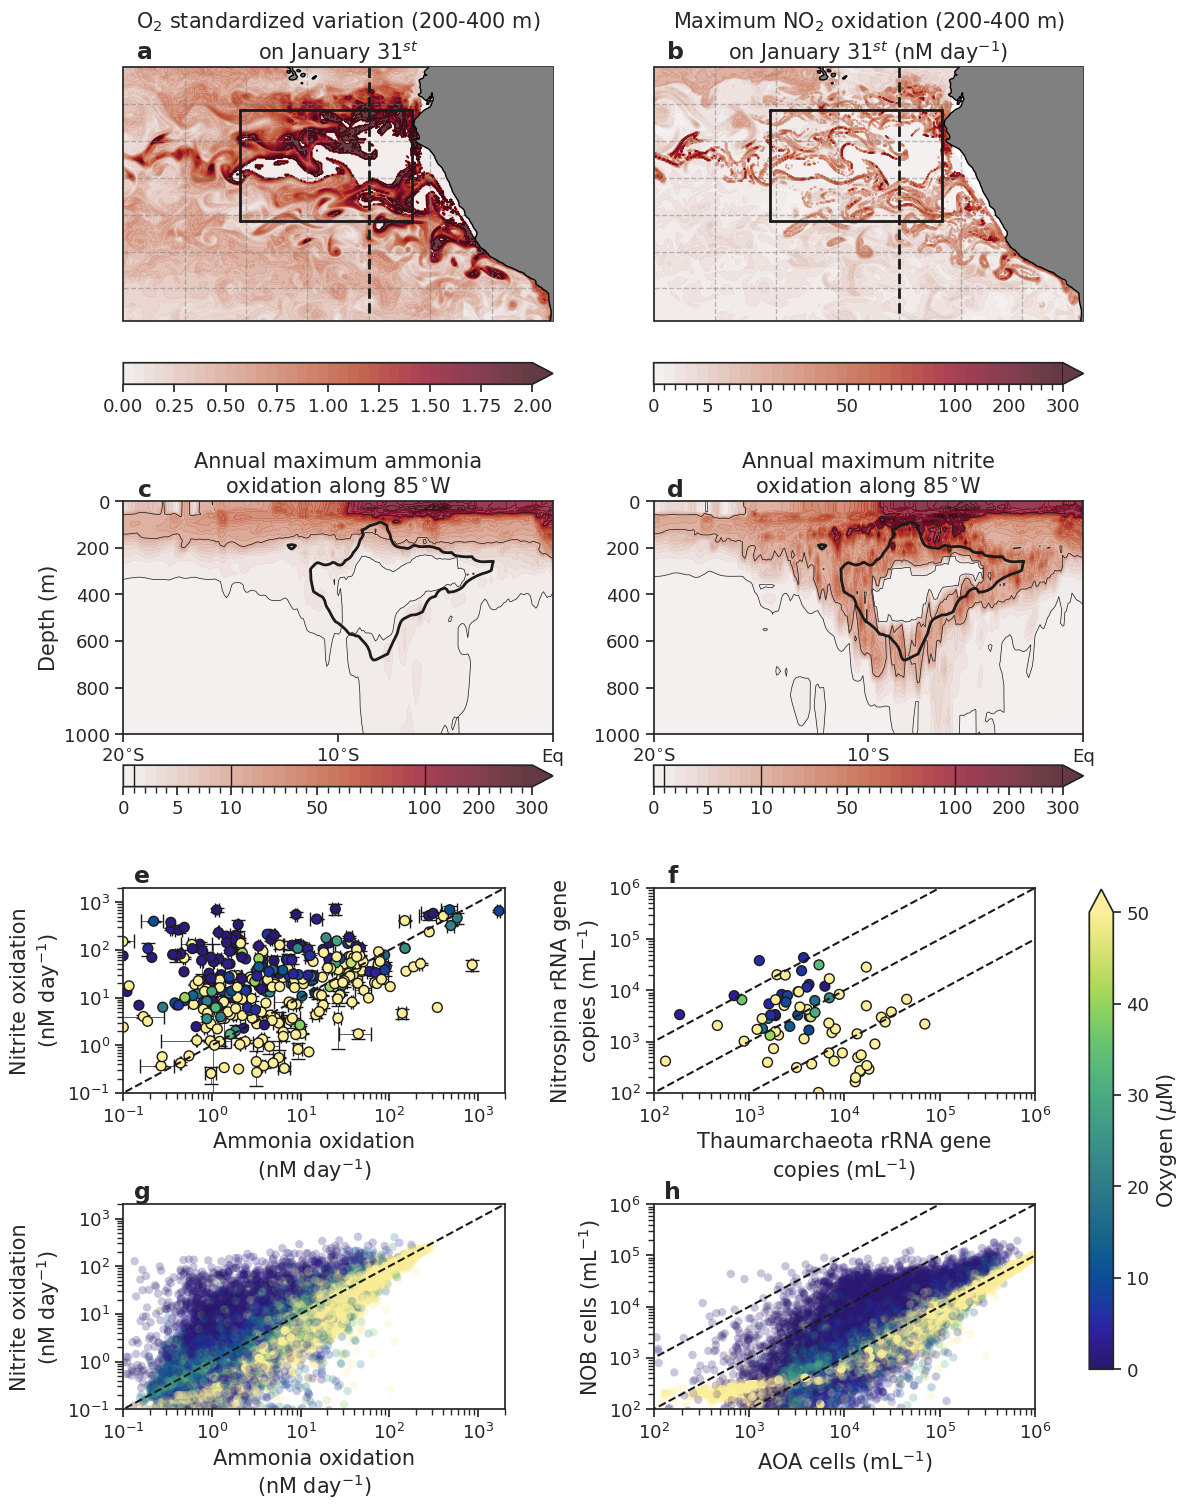

In [24]:

fig = plt.figure(facecolor='w', figsize=(12,16))
gs = GridSpec(40,20)

ax1 = plt.subplot(gs[0:12,0:9], projection=proj)
ax2 = plt.subplot(gs[0:12,11:20], projection=proj)
ax3 = plt.subplot(gs[14:23,0:9])
ax4 = plt.subplot(gs[14:23,11:20])
ax5 = plt.subplot(gs[25:31,0:8])
ax6 = plt.subplot(gs[25:31,11:19])
ax7 = plt.subplot(gs[34:40,0:8])
ax8 = plt.subplot(gs[34:40,11:19])

ax1.set_extent([-105,-70,-20,0])
ax2.set_extent([-105,-70,-20,0])


p1 = ax1.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_oxyvar.isel(time=30), transform=ccrs.PlateCarree(), \
                  vmin=0, vmax=2, cmap=colmap1, levels=np.arange(0,2.01,0.05), extend='max')
ax1.plot((lon1,lon1),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon2,lon2),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon1,lon2),(lat1,lat1), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon1,lon2),(lat2,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)

p2 = ax2.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap1, norm=norm4, levels=levs4, transform=ccrs.PlateCarree(), extend='max')
ax2.plot((lon1,lon1),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon2,lon2),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon1,lon2),(lat1,lat1), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon1,lon2),(lat2,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)

# add transect to ax1 and ax2
ax1.plot((275,275),(-20,0), color='k', transform=ccrs.PlateCarree(), linewidth=2, zorder=3, linestyle='--')
ax2.plot((275,275),(-20,0), color='k', transform=ccrs.PlateCarree(), linewidth=2, zorder=3, linestyle='--')



p3 = ax3.contourf(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap4, norm=norm4, levels=levs4, extend='max')
c4 = ax4.contour(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4)
c4o2 = ax4.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


vmin = 0.0
vmax = 50.0
colmap = cmo.haline


ax5.errorbar(merged_rates['Ammonia oxidation'], merged_rates['Nitrite oxidation'], \
             xerr=merged_rates['Ammonia oxidation (standard deviation)'], yerr=merged_rates['Nitrite oxidation (standard deviation)'], \
             fmt='o', capsize=5, ms=0.1, ecolor='k', linewidth=0.5, zorder=1)
p5 = ax5.scatter(merged_rates['Ammonia oxidation'], merged_rates['Nitrite oxidation'], c=merged_rates['Oxygen'], \
            marker='o', s=50, cmap=colmap, vmin=vmin, vmax=vmax, zorder=2, alpha=1.0, edgecolor='k')

cols = merged_genes.columns
p6 = ax6.scatter(merged_genes[cols[2]]*1e-3, merged_genes[cols[6]]*1e-3, c=merged_genes['Oxygen'], \
                 marker='o', s=50, cmap=colmap, vmin=vmin, vmax=vmax, zorder=2, alpha=1.0, edgecolor='k')


stacked_z = allprofiles_z.stack(stacked_dim=['time','y_c','x_c'])
stacked_o2 = allprofiles_o2.stack(stacked_dim=['time','y_c','x_c'])
stacked_nox = allprofiles_nox.stack(stacked_dim=['time','y_c','x_c'])
stacked_nhx = allprofiles_nhx.stack(stacked_dim=['time','y_c','x_c'])
stacked_aoa = allprofiles_Caoa.stack(stacked_dim=['time','y_c','x_c'])
stacked_nob = allprofiles_Cnob.stack(stacked_dim=['time','y_c','x_c'])
stacked_nob2aoa = allprofiles_nob2aoa.stack(stacked_dim=['time','y_c','x_c'])

### create a random sampling of 10,000 profile from our array
size_of_array = len(stacked_z.coords['stacked_dim'])
print("Number of profiles in the box to randomly sample from =", size_of_array)
random_integers = np.random.randint(0, size_of_array, size=2000)

for ii,prof in enumerate(random_integers):
    if ii%100==0:
        print(ii)
    p7 = ax7.scatter(stacked_nhx.isel(stacked_dim=prof)*86400*1e3, stacked_nox.isel(stacked_dim=prof)*86400*1e3, c=stacked_o2.isel(stacked_dim=prof), \
                     cmap=colmap, edgecolor='none', vmin=vmin, vmax=vmax, alpha=0.25)
    p8 = ax8.scatter(stacked_aoa.isel(stacked_dim=prof), stacked_nob.isel(stacked_dim=prof), c=stacked_o2.isel(stacked_dim=prof), \
                     cmap=colmap, edgecolor='none', vmin=vmin, vmax=vmax, alpha=0.25)


ax5.set_xscale('log')
ax5.set_yscale('log')
ax7.set_xscale('log')
ax7.set_yscale('log')
ax5.plot((0,2000),(0,2000), 'k--')
ax7.plot((0,2000),(0,2000), 'k--')


ax6.plot((1,1e6),(1,1e6), 'k--', zorder=3)
ax6.plot((10,1e7),(1,1e6), 'k--', zorder=3)
ax6.plot((1,1e6),(10,1e7), 'k--', zorder=3)
ax6.set_xscale('log')
ax6.set_yscale('log')

ax8.plot((1,1e6),(1,1e6), 'k--', zorder=3)
ax8.plot((10,1e7),(1,1e6), 'k--', zorder=3)
ax8.plot((1,1e6),(10,1e7), 'k--', zorder=3)
ax8.set_xscale('log')
ax8.set_yscale('log')

ax5.set_xlim(0.1,2000)
ax5.set_ylim(0.1,2000)
ax6.set_xlim(100,1e6)
ax6.set_ylim(100,1e6)
ax7.set_xlim(0.1,2000)
ax7.set_ylim(0.1,2000)
ax8.set_xlim(100,1e6)
ax8.set_ylim(100,1e6)


ax5.set_xlabel("Ammonia oxidation\n(nM day$^{-1}$)", fontsize=fslab)
ax5.set_ylabel("Nitrite oxidation\n(nM day$^{-1}$)", fontsize=fslab)
ax6.set_xlabel('Thaumarchaeota rRNA gene\ncopies (mL$^{-1}$)', fontsize=fslab)
ax6.set_ylabel('Nitrospina rRNA gene\ncopies (mL$^{-1}$)', fontsize=fslab)
ax7.set_xlabel("Ammonia oxidation\n(nM day$^{-1}$)", fontsize=fslab)
ax7.set_ylabel("Nitrite oxidation\n(nM day$^{-1}$)", fontsize=fslab)
ax8.set_xlabel("AOA cells (mL$^{-1}$)", fontsize=fslab)
ax8.set_ylabel("NOB cells (mL$^{-1}$)", fontsize=fslab)


cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=np.arange(0,2.01,0.05)[::5], pad=0.1)#, shrink=0.75, aspect=15)
cb2 = plt.colorbar(p2, ax=ax2, orientation='horizontal', ticks=levs4[[0,5,10,18,28,33,38]], pad=0.1)#, shrink=0.75, aspect=15)
cb3 = plt.colorbar(p3, ax=ax3, orientation='horizontal', ticks=levs4[[0,5,10,18,28,33,38]], pad=0.1)
cb4 = plt.colorbar(p4, ax=ax4, orientation='horizontal', ticks=levs4[[0,5,10,18,28,33,38]], pad=0.1)
cbax5 = fig.add_axes([0.905, 0.1, 0.02,0.3])
cb5 = plt.colorbar(p5, cax=cbax5, orientation='vertical', extend='max')


cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)

#cb2.ax.set_xlabel("(nM day$^{-1}$)", fontsize=fslab)
#cb3.ax.set_xlabel("(nM day$^{-1}$)", fontsize=fslab)
#cb4.ax.set_xlabel("(nM day$^{-1}$)", fontsize=fslab)
cb5.ax.set_ylabel("Oxygen ($\mu$M)", fontsize=fslab)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)


#ax3.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True)
#ax4.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True, labelleft=False)
ax3.tick_params(labelsize=fstic)
ax4.tick_params(labelsize=fstic)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic)
ax7.tick_params(labelsize=fstic)
ax8.tick_params(labelsize=fstic)


# parallels/meridiens
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl1.xlabels_top = False
#gl1.ylabels_right = False
#gl1.xformatter = LONGITUDE_FORMATTER
#gl1.yformatter = LATITUDE_FORMATTER
#gl1.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
#gl1.ylabel_style = {'size': 12, 'color': 'black'}

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl2.xlabels_top = False
#gl2.ylabels_right = False
#gl2.xformatter = LONGITUDE_FORMATTER
#gl2.yformatter = LATITUDE_FORMATTER
#gl2.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
#gl2.ylabel_style = {'size': 12, 'color': 'black'}

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.coastlines(zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.coastlines(zorder=3)

ax3.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax3.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
ax4.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax4.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])

ax3.set_ylabel("Depth (m)", fontsize=fslab)

ax1.set_title("O$_2$ standardized variation (200-400 m)\non January 31$^{st}$", fontsize=fslab)
ax2.set_title("Maximum NO$_2$ oxidation (200-400 m)\non January 31$^{st}$ (nM day$^{-1}$)", fontsize=fslab)
ax3.set_title("Annual maximum ammonia\noxidation along 85$^{\circ}$W", fontsize=fslab)
ax4.set_title("Annual maximum nitrite\noxidation along 85$^{\circ}$W", fontsize=fslab)

plt.subplots_adjust(top=0.95, left=0.1, right=0.9, wspace=0.1, hspace=0.2, bottom=0.075)

### add the letters
xx = 0.05; yy = 1.05
plt.text(xx,yy+0.01,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy+0.01,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy+0.01,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy+0.01,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy+0.01,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy+0.01,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)

cb3.ax.vlines(1, 0,1, color='k', linewidth=1.0)
cb3.ax.vlines(10, 0,1, color='k', linewidth=1.0)
cb3.ax.vlines(100, 0,1, color='k', linewidth=1.0)
cb4.ax.vlines(1, 0,1, color='k', linewidth=1.0)
cb4.ax.vlines(10, 0,1, color='k', linewidth=1.0)
cb4.ax.vlines(100, 0,1, color='k', linewidth=1.0)



In [25]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig3_sensitivityexp_nob1p0.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig3_sensitivityexp_nob1p0.pdf", dpi=500)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig3_sensitivityexp_nob1p0_transparent.png", dpi=300, transparent=True)


## alternative Figure

NameError: name 'profiles_o2' is not defined

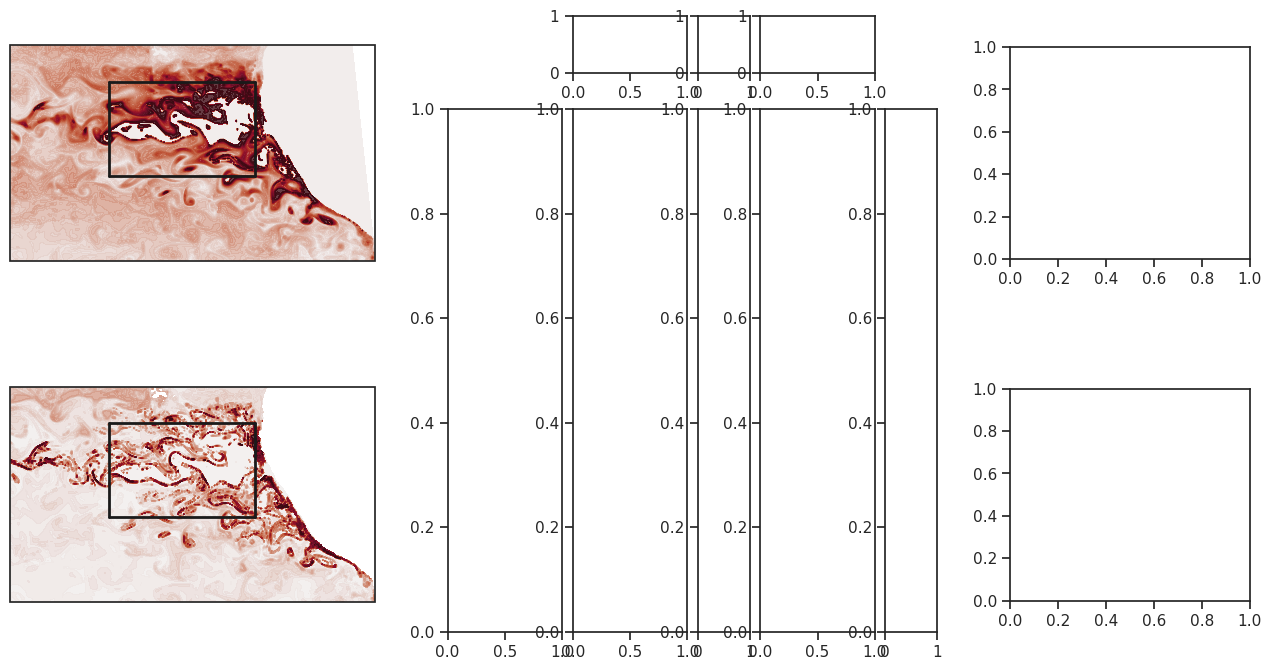

In [28]:

fig = plt.figure(facecolor='w', figsize=(16,8))
gs = GridSpec(20,20)

ax1 = plt.subplot(gs[0:9,0:6], projection=proj)
ax1.set_extent([-105,-70,-20,0])
ax2 = plt.subplot(gs[11:20,0:6], projection=proj)
ax2.set_extent([-105,-70,-20,0])

ax3 = plt.subplot(gs[3:20,7:9])
ax4 = plt.subplot(gs[3:20,9:11])
ax4b = plt.subplot(gs[3:20,11:12])
ax5 = plt.subplot(gs[3:20,12:14])
ax5b = plt.subplot(gs[3:20,14:15])
ax4t = plt.subplot(gs[0:2,9:11])
ax4bt = plt.subplot(gs[0:2,11:12])
ax5t = plt.subplot(gs[0:2,12:14])

ax6 = plt.subplot(gs[1:8,16:20])
ax7 = plt.subplot(gs[12:19,16:20])

ax4bt.patch.set_alpha(0.0)

p1 = ax1.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_oxyvar.isel(time=30), transform=ccrs.PlateCarree(), \
                  vmin=0, vmax=2, cmap=colmap1, levels=np.arange(0,2.01,0.05), extend='max')
#c1 = ax1.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
#                 levels=conts4, colors=contcol, linewidths=contl4, transform=ccrs.PlateCarree())
#ax1.plot((longitude,longitude),(-20,0), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
#ax1.scatter(longitude, latitude, marker="*", s=200, color='grey', edgecolor='k', transform=ccrs.PlateCarree(), zorder=3)
ax1.plot((lon1,lon1),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon2,lon2),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon1,lon2),(lat1,lat1), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon1,lon2),(lat2,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)

p2 = ax2.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap1, norm=norm4, levels=levs4, transform=ccrs.PlateCarree(), extend='max')
#c2 = ax2.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
#                 levels=conts4, colors=contcol, linewidths=contl4, transform=ccrs.PlateCarree())
#ax2.plot((longitude,longitude),(-20,0), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
#ax2.scatter(longitude, latitude, marker="*", s=200, color='grey', edgecolor='k', transform=ccrs.PlateCarree(), zorder=3)
ax2.plot((lon1,lon1),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon2,lon2),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon1,lon2),(lat1,lat1), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon1,lon2),(lat2,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)


alf=0.75
ax3.plot(profiles_o2[3,:], profile50_z, color='k', linestyle='-', label="oxygen", alpha=alf)
ax3.fill_betweenx(profile50_z, profiles_o2[2,:], profiles_o2[4,:], color='k', alpha=alf*0.5)
ax3.fill_betweenx(profile50_z, profiles_o2[1,:], profiles_o2[5,:], color='k', alpha=alf*0.25)
ax3.fill_betweenx(profile50_z, profiles_o2[0,:], profiles_o2[6,:], color='k', alpha=alf*0.1)

ax4.plot(profiles_nox[3,:]*86400*1e3, profile50_z, color='firebrick', linestyle='-', label="nitrite oxidation", alpha=alf)
ax4.fill_betweenx(profile50_z, profiles_nox[2,:]*86400*1e3, profiles_nox[4,:]*86400*1e3, color='firebrick', alpha=alf*0.5)
ax4.fill_betweenx(profile50_z, profiles_nox[1,:]*86400*1e3, profiles_nox[5,:]*86400*1e3, color='firebrick', alpha=alf*0.25)
ax4.fill_betweenx(profile50_z, profiles_nox[0,:]*86400*1e3, profiles_nox[6,:]*86400*1e3, color='firebrick', alpha=alf*0.1)

ax4b.plot(profiles_nox[3,:]*86400*1e3, profile50_z, color='firebrick', linestyle='-', label="nitrite oxidation", alpha=alf)
ax4b.fill_betweenx(profile50_z, profiles_nox[2,:]*86400*1e3, profiles_nox[4,:]*86400*1e3, color='firebrick', alpha=alf*0.5)
ax4b.fill_betweenx(profile50_z, profiles_nox[1,:]*86400*1e3, profiles_nox[5,:]*86400*1e3, color='firebrick', alpha=alf*0.25)
ax4b.fill_betweenx(profile50_z, profiles_nox[0,:]*86400*1e3, profiles_nox[6,:]*86400*1e3, color='firebrick', alpha=alf*0.1)

#ax4.plot(profiles_nhx[3,:]*86400*1e3, profile50_z, color='royalblue', linestyle='-', label="ammonia oxidation", alpha=alf)
#ax4.fill_betweenx(profile50_z, profiles_nhx[2,:]*86400*1e3, profiles_nhx[4,:]*86400*1e3, color='royalblue', alpha=alf*0.5)
#ax4.fill_betweenx(profile50_z, profiles_nhx[1,:]*86400*1e3, profiles_nhx[5,:]*86400*1e3, color='royalblue', alpha=alf*0.25)
#ax4.fill_betweenx(profile50_z, profiles_nhx[0,:]*86400*1e3, profiles_nhx[6,:]*86400*1e3, color='royalblue', alpha=alf*0.1)

ax5.plot(profiles_nob2aoa[3,:], profile50_z, color='k', linestyle='-', label="NOB:AOA", alpha=alf)
ax5.fill_betweenx(profile50_z, profiles_nob2aoa[2,:], profiles_nob2aoa[4,:], color='k', alpha=alf*0.5)
ax5.fill_betweenx(profile50_z, profiles_nob2aoa[1,:], profiles_nob2aoa[5,:], color='k', alpha=alf*0.25)
ax5.fill_betweenx(profile50_z, profiles_nob2aoa[0,:], profiles_nob2aoa[6,:], color='k', alpha=alf*0.1)

ax5b.plot(profiles_nob2aoa[3,:], profile50_z, color='k', linestyle='-', label="NOB:AOA", alpha=alf)
ax5b.fill_betweenx(profile50_z, profiles_nob2aoa[2,:], profiles_nob2aoa[4,:], color='k', alpha=alf*0.5)
ax5b.fill_betweenx(profile50_z, profiles_nob2aoa[1,:], profiles_nob2aoa[5,:], color='k', alpha=alf*0.25)
ax5b.fill_betweenx(profile50_z, profiles_nob2aoa[0,:], profiles_nob2aoa[6,:], color='k', alpha=alf*0.1)

#ax4.plot(profiles_nhx[2,:]*86400*1e3, profile50_z, color='royalblue', linestyle='-', label="nitrite oxidation", alpha=alf)
#ax4.fill_betweenx(profile50_z, profiles_nhx[1,:]*86400*1e3, profiles_nhx[3,:]*86400*1e3, color='royalblue', alpha=alf*0.2)
#ax4.fill_betweenx(profile50_z, profiles_nhx[0,:]*86400*1e3, profiles_nhx[4,:]*86400*1e3, color='royalblue', alpha=alf*0.1)

#ax3.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6,0.6), ncols=1)
#ax4.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6,0.6), ncols=1)
#ax5.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6,0.6), ncols=1)

p6 = ax6.contourf(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c6 = ax6.contour(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                 levels=conts3, colors=contcol, linewidths=contl3)
c6o2 = ax6.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p7 = ax7.contourf(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap4, norm=norm4, levels=levs4, extend='max')
c7 = ax7.contour(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4)
c7o2 = ax7.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


#ax5.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
#ax6.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)


cb1 = plt.colorbar(p1, ax=ax1, orientation='vertical', ticks=np.arange(0,2.01,0.05)[::5], shrink=0.75, aspect=15)
cb2 = plt.colorbar(p2, ax=ax2, orientation='vertical', ticks=levs4[[0,5,10,18,28,33,38]], shrink=0.75, aspect=15)
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs4[[0,5,10,18,28,33,38]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs4[[0,5,10,18,28,33,38]])

cb1.ax.tick_params(labelsize=fstic-2)
cb2.ax.tick_params(labelsize=fstic-2)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)

x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax3.set_ylim(y1,y2)
ax4.set_ylim(y1,y2)
ax5.set_ylim(y1,y2)
ax5b.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)


ax3.spines[['bottom','right']].set_visible(False)
ax4.spines[['bottom','right']].set_visible(False)
ax5.spines[['bottom','right']].set_visible(False)
ax3.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True)
ax4.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True, labelleft=False)
ax5.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True, labelleft=False)
ax6.tick_params(labelsize=fstic, labelbottom=False)
ax7.tick_params(labelsize=fstic)

ax4b.tick_params(labelsize=fstic, left=False, bottom=False, labelbottom=False, labelleft=False, top=True, labeltop=True)
ax4b.spines[['right','bottom','left']].set_visible(False)
ax5b.tick_params(labelsize=fstic, left=False, bottom=False, labelbottom=False, labelleft=False, top=True, labeltop=True)
ax5b.spines[['right','bottom','left']].set_visible(False)


# parallels/meridiens
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl1.xlabels_top = False
#gl1.ylabels_right = False
#gl1.xformatter = LONGITUDE_FORMATTER
#gl1.yformatter = LATITUDE_FORMATTER
#gl1.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
#gl1.ylabel_style = {'size': 12, 'color': 'black'}

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl2.xlabels_top = False
#gl2.ylabels_right = False
#gl2.xformatter = LONGITUDE_FORMATTER
#gl2.yformatter = LATITUDE_FORMATTER
#gl2.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
#gl2.ylabel_style = {'size': 12, 'color': 'black'}

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.coastlines(zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.coastlines(zorder=3)

ax3.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax6.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax7.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax7.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])


ax3.set_ylabel("Depth (m)", fontsize=fslab)
ax3.text(0.6,0.01,"Oxygen\n($\mu$M)", transform=ax3.transAxes, va='bottom', fontsize=fslab, rotation=90)
ax4.text(0.6,0.01,"Nitrite oxidation\n(nM day$^{-1}$)", transform=ax4.transAxes, va='bottom', fontsize=fslab, rotation=90)
ax5.text(0.6,0.01,"NOB:AOA\n(cells mL$^{-1}$)", transform=ax5.transAxes, va='bottom', fontsize=fslab, rotation=90)
ax6.set_ylabel("Depth (m)", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax7.set_ylabel("Depth (m)", fontsize=fslab)

ax1.set_title("O$_2$ standardized variation (200-400 m)\non January 31$^{st}$", fontsize=fslab)
ax2.set_title("Maximum NO$_2$ oxidation (200-400 m)\non January 31$^{st}$ (nM day$^{-1}$)", fontsize=fslab)
ax6.set_title("Annual maximum ammonia\noxidation along 85$^{\circ}$W\n(nM day$^{-1}$)", fontsize=fslab)
ax7.set_title("Annual maximum nitrite\noxidation along 85$^{\circ}$W\n(nM day$^{-1}$)", fontsize=fslab)


ax4t.spines[['top','right','bottom','left']].set_visible(False)
ax4t.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax4bt.spines[['top','right','bottom','left']].set_visible(False)
ax4bt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax5t.spines[['top','right','bottom','left']].set_visible(False)
ax5t.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

# collect the measured nitrite oxidation rates
san_nox = nit['NO2ox']
bab_nox = bab['NO2_ox']
all_nox = np.concatenate((san_nox, bab_nox))
# find the median and interquantile ranges
med = np.quantile(all_nox, 0.5)     # get the median of all the data in the top of AMZ
err = np.array((med - np.quantile(all_nox, 0.05), np.quantile(all_nox, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax4t.scatter(all_nox, np.ones(len(all_nox)), edgecolor='k', facecolor='goldenrod', s=30, marker='o', zorder=2, alpha=0.5)
ax4t.errorbar(med, 0, xerr=err[:,np.newaxis]-0.1, yerr=0, mfc='goldenrod', mec='k', ms=20, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot
ax4bt.scatter(all_nox, np.ones(len(all_nox)), edgecolor='k', facecolor='goldenrod', s=30, marker='o', zorder=2, alpha=0.5)
ax4bt.errorbar(med, 0, xerr=err[:,np.newaxis]-0.1, yerr=0, mfc='goldenrod', mec='k', ms=0, zorder=3, marker='o', capsize=5, capthick=1.5, ecolor='k') # plot

# find the median and interquantile ranges of NOB: AOA
med = np.quantile(bem_oxy, 0.5)     # get the median of all the data in the OMZ
err = np.array((med - np.quantile(bem_oxy, 0.05), np.quantile(bem_oxy, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5t.scatter(bem_oxy, np.ones(len(bem_oxy)), edgecolor='k', facecolor='skyblue', s=30, marker='o', zorder=2, alpha=0.5)
ax5t.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='royalblue', mec='k', ms=20, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot
#
med = np.quantile(bem_omz, 0.5)     # get the median of all the data in the OMZ
err = np.array((med - np.quantile(bem_omz, 0.05), np.quantile(bem_omz, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5t.scatter(bem_omz, np.ones(len(bem_omz)), edgecolor='k', facecolor='goldenrod', s=30, marker='o', zorder=2, alpha=0.5)
ax5t.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='goldenrod', mec='k', ms=20, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot

#ax5a.set_xlim(-20,250)
#ax3.set_xscale('log')
#ax4.set_xscale('log')
#ax4t.set_xscale('log')
#ax3.set_xlim(1e-2,5e2)
#ax4.set_xlim(1e-2,1e3)
#ax4t.set_xlim(1e-2,1e3); ax4t.set_ylim(-0.5,1.5)

ax4.set_xlim(-5,50)
ax5.set_xlim(-0.2,3.0)
ax4b.set_xlim(50,700)
ax5b.set_xlim(3.0,20.0)
ax4t.set_xlim(-5,50); ax4t.set_ylim(-0.5,1.5)
ax4bt.set_xlim(50,700); ax4bt.set_ylim(-0.5,1.5)
ax5t.set_xlim(-0.2,3.0); ax5t.set_ylim(-0.5,1.5)

ax4b.set_xticks(np.array([250,500]), np.array([250,500]), rotation=90)

plt.subplots_adjust(top=0.95, left=0.125, right=0.925, wspace=0.5, hspace=0.1, bottom=0.075)

### add the letters
xx = 0.05; yy = 1.05
plt.text(xx,yy+0.01,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy+0.01,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy+0.05,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy+0.01,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4t.transAxes)
plt.text(xx,yy+0.01,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5t.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)

# Add the break mark
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax5.transAxes, color='k', clip_on=False)
ax5.plot((1-d*2.5, 1+d*2.5), (1-d, 1+d), **kwargs)  # Bottom-right diagonal
kwargs.update(transform=ax5b.transAxes)  # Switch to the right axes
ax5b.plot((-d*5, +d*5), (1-d, 1+d), **kwargs)  # Bottom-left diagonal
kwargs = dict(transform=ax4.transAxes, color='k', clip_on=False)
ax4.plot((1-d*2.5, 1+d*2.5), (1-d, 1+d), **kwargs)  # Bottom-right diagonal
kwargs.update(transform=ax4b.transAxes)  # Switch to the right axes
ax4b.plot((-d*5, +d*5), (1-d, 1+d), **kwargs)  # Bottom-left diagonal



In [50]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_localstats.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_localstats.pdf", dpi=500)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_localstats_transparent.png", dpi=300, transparent=True)


# alternative figure with scatter profiles rather than median +- interquartile ranges

0
100
200
300
400
500
600
700
800
900


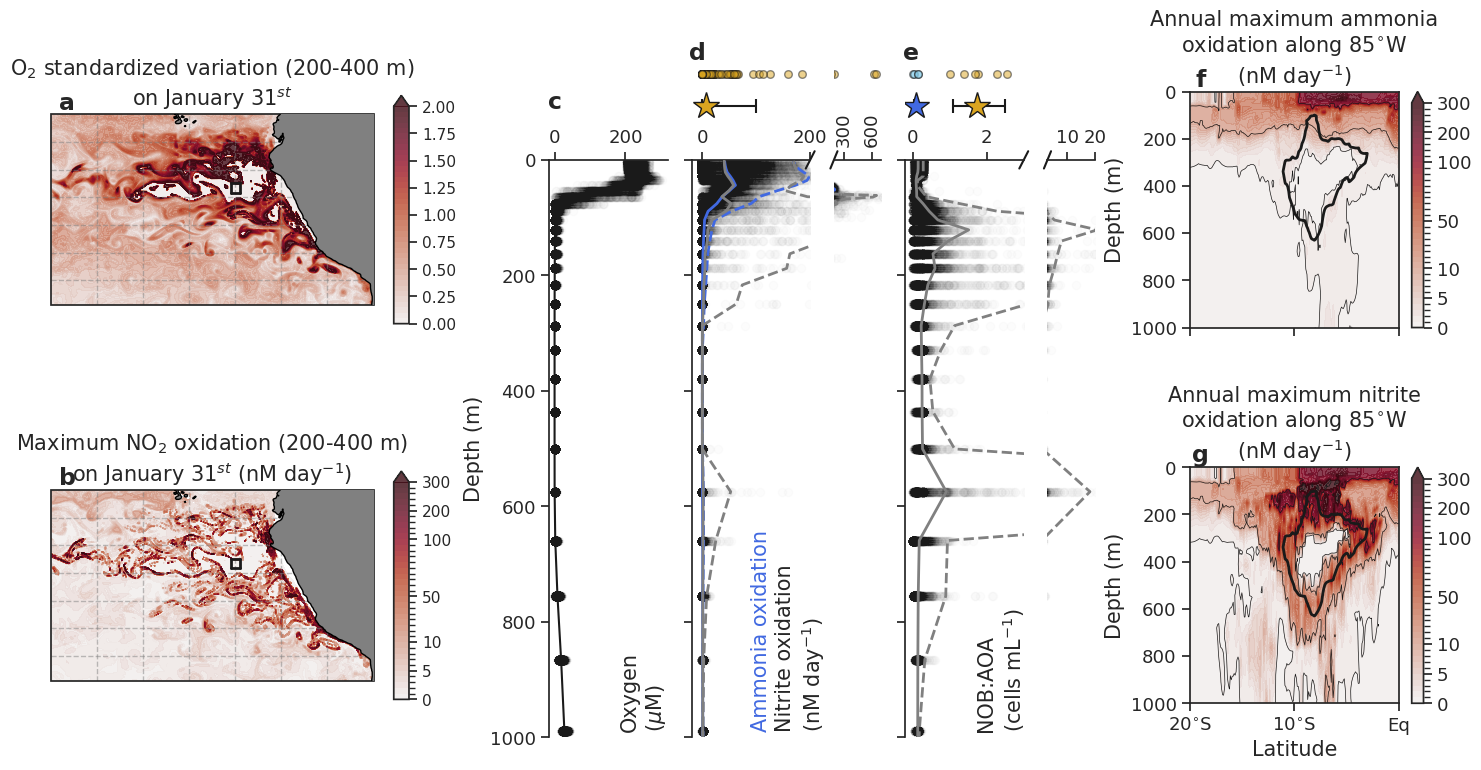

In [34]:

fig = plt.figure(facecolor='w', figsize=(16,8))
gs = GridSpec(20,20)

ax1 = plt.subplot(gs[0:9,0:6], projection=proj)
ax1.set_extent([-105,-70,-20,0])
ax2 = plt.subplot(gs[11:20,0:6], projection=proj)
ax2.set_extent([-105,-70,-20,0])

ax3 = plt.subplot(gs[3:20,7:9])
ax4 = plt.subplot(gs[3:20,9:11])
ax4b = plt.subplot(gs[3:20,11:12])
ax5 = plt.subplot(gs[3:20,12:14])
ax5b = plt.subplot(gs[3:20,14:15])
ax4t = plt.subplot(gs[0:2,9:11])
ax4bt = plt.subplot(gs[0:2,11:12])
ax5t = plt.subplot(gs[0:2,12:14])

ax6 = plt.subplot(gs[1:8,16:20])
ax7 = plt.subplot(gs[12:19,16:20])

ax4bt.patch.set_alpha(0.0)

p1 = ax1.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_oxyvar.isel(time=30), transform=ccrs.PlateCarree(), \
                  vmin=0, vmax=2, cmap=colmap1, levels=np.arange(0,2.01,0.05), extend='max')
#c1 = ax1.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
#                 levels=conts4, colors=contcol, linewidths=contl4, transform=ccrs.PlateCarree())
#ax1.plot((longitude,longitude),(-20,0), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
#ax1.scatter(longitude, latitude, marker="*", s=200, color='grey', edgecolor='k', transform=ccrs.PlateCarree(), zorder=3)
ax1.plot((lon1,lon1),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon2,lon2),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon1,lon2),(lat1,lat1), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.plot((lon1,lon2),(lat2,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)

p2 = ax2.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap1, norm=norm4, levels=levs4, transform=ccrs.PlateCarree(), extend='max')
#c2 = ax2.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
#                 levels=conts4, colors=contcol, linewidths=contl4, transform=ccrs.PlateCarree())
#ax2.plot((longitude,longitude),(-20,0), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
#ax2.scatter(longitude, latitude, marker="*", s=200, color='grey', edgecolor='k', transform=ccrs.PlateCarree(), zorder=3)
ax2.plot((lon1,lon1),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon2,lon2),(lat1,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon1,lon2),(lat1,lat1), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax2.plot((lon1,lon2),(lat2,lat2), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)


alf=1.0; wid = 2.0
stacked_o2 = allprofiles_o2.stack(stacked_dim=['time','y_c','x_c'])
stacked_nox = allprofiles_nox.stack(stacked_dim=['time','y_c','x_c'])
stacked_nob2aoa = allprofiles_nob2aoa.stack(stacked_dim=['time','y_c','x_c'])

### create a random sampling of 10,000 profile from our array
random_integers = np.random.randint(0, 48180, size=1000)

for ii,prof in enumerate(random_integers):
    if ii%100==0:
        print(ii)
    ax3.scatter(stacked_o2.isel(stacked_dim=prof), profile50_z, color='k', alpha=0.01, zorder=1)
    ax4.scatter(stacked_nox.isel(stacked_dim=prof)*86400*1e3, profile50_z, color='k', alpha=0.01, zorder=1)
    ax4b.scatter(stacked_nox.isel(stacked_dim=prof)*86400*1e3, profile50_z, color='k', alpha=0.01, zorder=1)
    ax5.scatter(stacked_nob2aoa.isel(stacked_dim=prof), profile50_z, color='k', alpha=0.01, zorder=1)
    ax5b.scatter(stacked_nob2aoa.isel(stacked_dim=prof), profile50_z, color='k', alpha=0.01, zorder=1)

ax3.plot(mean_o2, profile50_z, color='k', linestyle='-', label="oxygen", alpha=alf)

ax4.plot(mean_nox*86400*1e3, profile50_z, color='grey', linestyle='-', label="nitrite oxidation", alpha=alf, linewidth=wid, zorder=3)
ax4.plot(mean_nhx*86400*1e3, profile50_z, color='royalblue', linestyle='-', label="ammonia oxidation", alpha=alf, linewidth=wid, zorder=2)
ax4.plot(profiles_nox[6,:]*86400*1e3, profile50_z, color='grey', linestyle='--', alpha=alf, linewidth=wid, zorder=3)
ax4.plot(profiles_nhx[6,:]*86400*1e3, profile50_z, color='royalblue', linestyle='--', alpha=alf, linewidth=wid, zorder=2)

ax4b.plot(mean_nox*86400*1e3, profile50_z, color='grey', linestyle='-', label="nitrite oxidation", alpha=alf, linewidth=wid, zorder=3)
ax4b.plot(mean_nhx*86400*1e3, profile50_z, color='royalblue', linestyle='-', label="ammonia oxidation", alpha=alf, linewidth=wid, zorder=2)
ax4b.plot(profiles_nox[6,:]*86400*1e3, profile50_z, color='grey', linestyle='--', alpha=alf, linewidth=wid, zorder=3)
ax4b.plot(profiles_nhx[6,:]*86400*1e3, profile50_z, color='royalblue', linestyle='--', alpha=alf, linewidth=wid, zorder=2)

ax5.plot(mean_nob2aoa, profile50_z, color='grey', linestyle='-', label="NOB:AOA", alpha=alf, linewidth=wid)
ax5b.plot(mean_nob2aoa, profile50_z, color='grey', linestyle='-', alpha=alf, linewidth=wid)
ax5.plot(profiles_nob2aoa[6,:], profile50_z, color='grey', linestyle='--', alpha=alf, linewidth=wid)
ax5b.plot(profiles_nob2aoa[6,:], profile50_z, color='grey', linestyle='--', alpha=alf, linewidth=wid)


'''    
#ax3.plot(profiles_o2[3,:], profile50_z, color='k', linestyle='-', label="oxygen", alpha=alf)
#ax3.fill_betweenx(profile50_z, profiles_o2[2,:], profiles_o2[4,:], color='k', alpha=alf*0.5)
#ax3.fill_betweenx(profile50_z, profiles_o2[1,:], profiles_o2[5,:], color='k', alpha=alf*0.25)
#ax3.fill_betweenx(profile50_z, profiles_o2[0,:], profiles_o2[6,:], color='k', alpha=alf*0.1)

ax4.plot(profiles_nox[3,:]*86400*1e3, profile50_z, color='firebrick', linestyle='-', label="nitrite oxidation", alpha=alf)
ax4.fill_betweenx(profile50_z, profiles_nox[2,:]*86400*1e3, profiles_nox[4,:]*86400*1e3, color='firebrick', alpha=alf*0.5)
ax4.fill_betweenx(profile50_z, profiles_nox[1,:]*86400*1e3, profiles_nox[5,:]*86400*1e3, color='firebrick', alpha=alf*0.25)
ax4.fill_betweenx(profile50_z, profiles_nox[0,:]*86400*1e3, profiles_nox[6,:]*86400*1e3, color='firebrick', alpha=alf*0.1)

ax4b.plot(profiles_nox[3,:]*86400*1e3, profile50_z, color='firebrick', linestyle='-', label="nitrite oxidation", alpha=alf)
ax4b.fill_betweenx(profile50_z, profiles_nox[2,:]*86400*1e3, profiles_nox[4,:]*86400*1e3, color='firebrick', alpha=alf*0.5)
ax4b.fill_betweenx(profile50_z, profiles_nox[1,:]*86400*1e3, profiles_nox[5,:]*86400*1e3, color='firebrick', alpha=alf*0.25)
ax4b.fill_betweenx(profile50_z, profiles_nox[0,:]*86400*1e3, profiles_nox[6,:]*86400*1e3, color='firebrick', alpha=alf*0.1)

#ax4.plot(profiles_nhx[3,:]*86400*1e3, profile50_z, color='royalblue', linestyle='-', label="ammonia oxidation", alpha=alf)
#ax4.fill_betweenx(profile50_z, profiles_nhx[2,:]*86400*1e3, profiles_nhx[4,:]*86400*1e3, color='royalblue', alpha=alf*0.5)
#ax4.fill_betweenx(profile50_z, profiles_nhx[1,:]*86400*1e3, profiles_nhx[5,:]*86400*1e3, color='royalblue', alpha=alf*0.25)
#ax4.fill_betweenx(profile50_z, profiles_nhx[0,:]*86400*1e3, profiles_nhx[6,:]*86400*1e3, color='royalblue', alpha=alf*0.1)

ax5.plot(profiles_nob2aoa[3,:], profile50_z, color='k', linestyle='-', label="NOB:AOA", alpha=alf)
ax5.fill_betweenx(profile50_z, profiles_nob2aoa[2,:], profiles_nob2aoa[4,:], color='k', alpha=alf*0.5)
ax5.fill_betweenx(profile50_z, profiles_nob2aoa[1,:], profiles_nob2aoa[5,:], color='k', alpha=alf*0.25)
ax5.fill_betweenx(profile50_z, profiles_nob2aoa[0,:], profiles_nob2aoa[6,:], color='k', alpha=alf*0.1)

ax5b.plot(profiles_nob2aoa[3,:], profile50_z, color='k', linestyle='-', label="NOB:AOA", alpha=alf)
ax5b.fill_betweenx(profile50_z, profiles_nob2aoa[2,:], profiles_nob2aoa[4,:], color='k', alpha=alf*0.5)
ax5b.fill_betweenx(profile50_z, profiles_nob2aoa[1,:], profiles_nob2aoa[5,:], color='k', alpha=alf*0.25)
ax5b.fill_betweenx(profile50_z, profiles_nob2aoa[0,:], profiles_nob2aoa[6,:], color='k', alpha=alf*0.1)

#ax4.plot(profiles_nhx[2,:]*86400*1e3, profile50_z, color='royalblue', linestyle='-', label="nitrite oxidation", alpha=alf)
#ax4.fill_betweenx(profile50_z, profiles_nhx[1,:]*86400*1e3, profiles_nhx[3,:]*86400*1e3, color='royalblue', alpha=alf*0.2)
#ax4.fill_betweenx(profile50_z, profiles_nhx[0,:]*86400*1e3, profiles_nhx[4,:]*86400*1e3, color='royalblue', alpha=alf*0.1)

#ax3.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6,0.6), ncols=1)
#ax4.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6,0.6), ncols=1)
#ax5.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.6,0.6), ncols=1)
'''


p6 = ax6.contourf(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c6 = ax6.contour(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                 levels=conts3, colors=contcol, linewidths=contl3)
c6o2 = ax6.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p7 = ax7.contourf(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap4, norm=norm4, levels=levs4, extend='max')
c7 = ax7.contour(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4)
c7o2 = ax7.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


#ax5.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
#ax6.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)


cb1 = plt.colorbar(p1, ax=ax1, orientation='vertical', ticks=np.arange(0,2.01,0.05)[::5], shrink=0.75, aspect=15)
cb2 = plt.colorbar(p2, ax=ax2, orientation='vertical', ticks=levs4[[0,5,10,18,28,33,38]], shrink=0.75, aspect=15)
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs4[[0,5,10,18,28,33,38]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs4[[0,5,10,18,28,33,38]])

cb1.ax.tick_params(labelsize=fstic-2)
cb2.ax.tick_params(labelsize=fstic-2)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)

x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax3.set_ylim(y1,y2)
ax4.set_ylim(y1,y2)
ax5.set_ylim(y1,y2)
ax5b.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)


ax3.spines[['bottom','right']].set_visible(False)
ax4.spines[['bottom','right']].set_visible(False)
ax5.spines[['bottom','right']].set_visible(False)
ax3.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True)
ax4.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True, labelleft=False)
ax5.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True, labelleft=False)
ax6.tick_params(labelsize=fstic, labelbottom=False)
ax7.tick_params(labelsize=fstic)

ax4b.tick_params(labelsize=fstic, left=False, bottom=False, labelbottom=False, labelleft=False, top=True, labeltop=True)
ax4b.spines[['right','bottom','left']].set_visible(False)
ax5b.tick_params(labelsize=fstic, left=False, bottom=False, labelbottom=False, labelleft=False, top=True, labeltop=True)
ax5b.spines[['right','bottom','left']].set_visible(False)


# parallels/meridiens
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl1.xlabels_top = False
#gl1.ylabels_right = False
#gl1.xformatter = LONGITUDE_FORMATTER
#gl1.yformatter = LATITUDE_FORMATTER
#gl1.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
#gl1.ylabel_style = {'size': 12, 'color': 'black'}

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
#gl2.xlabels_top = False
#gl2.ylabels_right = False
#gl2.xformatter = LONGITUDE_FORMATTER
#gl2.yformatter = LATITUDE_FORMATTER
#gl2.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
#gl2.ylabel_style = {'size': 12, 'color': 'black'}

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.coastlines(zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.coastlines(zorder=3)

ax3.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax6.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax7.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax7.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])


ax3.set_ylabel("Depth (m)", fontsize=fslab)
ax3.text(0.6,0.01,"Oxygen\n($\mu$M)", transform=ax3.transAxes, va='bottom', fontsize=fslab, rotation=90)
ax4.text(0.5,0.01,"Ammonia oxidation", transform=ax4.transAxes, va='bottom', fontsize=fslab, rotation=90, color='royalblue')
ax4.text(0.7,0.01,"Nitrite oxidation\n(nM day$^{-1}$)", transform=ax4.transAxes, va='bottom', fontsize=fslab, rotation=90)
ax5.text(0.6,0.01,"NOB:AOA\n(cells mL$^{-1}$)", transform=ax5.transAxes, va='bottom', fontsize=fslab, rotation=90)
ax6.set_ylabel("Depth (m)", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax7.set_ylabel("Depth (m)", fontsize=fslab)

ax1.set_title("O$_2$ standardized variation (200-400 m)\non January 31$^{st}$", fontsize=fslab)
ax2.set_title("Maximum NO$_2$ oxidation (200-400 m)\non January 31$^{st}$ (nM day$^{-1}$)", fontsize=fslab)
ax6.set_title("Annual maximum ammonia\noxidation along 85$^{\circ}$W\n(nM day$^{-1}$)", fontsize=fslab)
ax7.set_title("Annual maximum nitrite\noxidation along 85$^{\circ}$W\n(nM day$^{-1}$)", fontsize=fslab)


ax4t.spines[['top','right','bottom','left']].set_visible(False)
ax4t.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax4bt.spines[['top','right','bottom','left']].set_visible(False)
ax4bt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax5t.spines[['top','right','bottom','left']].set_visible(False)
ax5t.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

# collect the measured nitrite oxidation rates
san_nox = nit['NO2ox']
bab_nox = bab['NO2_ox']
all_nox = np.concatenate((san_nox, bab_nox))
# find the median and interquantile ranges
med = np.quantile(all_nox, 0.5)     # get the median of all the data in the top of AMZ
err = np.array((med - np.quantile(all_nox, 0.05), np.quantile(all_nox, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax4t.scatter(all_nox, np.ones(len(all_nox)), edgecolor='k', facecolor='goldenrod', s=30, marker='o', zorder=2, alpha=0.5)
ax4t.errorbar(med, 0, xerr=err[:,np.newaxis]-0.1, yerr=0, mfc='goldenrod', mec='k', ms=20, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot
ax4bt.scatter(all_nox, np.ones(len(all_nox)), edgecolor='k', facecolor='goldenrod', s=30, marker='o', zorder=2, alpha=0.5)
ax4bt.errorbar(med, 0, xerr=err[:,np.newaxis]-0.1, yerr=0, mfc='goldenrod', mec='k', ms=0, zorder=3, marker='o', capsize=5, capthick=1.5, ecolor='k') # plot

# find the median and interquantile ranges of NOB: AOA
med = np.quantile(bem_oxy, 0.5)     # get the median of all the data in the OMZ
err = np.array((med - np.quantile(bem_oxy, 0.05), np.quantile(bem_oxy, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5t.scatter(bem_oxy, np.ones(len(bem_oxy)), edgecolor='k', facecolor='skyblue', s=30, marker='o', zorder=2, alpha=0.5)
ax5t.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='royalblue', mec='k', ms=20, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot
#
med = np.quantile(bem_omz, 0.5)     # get the median of all the data in the OMZ
err = np.array((med - np.quantile(bem_omz, 0.05), np.quantile(bem_omz, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5t.scatter(bem_omz, np.ones(len(bem_omz)), edgecolor='k', facecolor='goldenrod', s=30, marker='o', zorder=2, alpha=0.5)
ax5t.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='goldenrod', mec='k', ms=20, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot

#ax5a.set_xlim(-20,250)
#ax3.set_xscale('log')
#ax4.set_xscale('log')
#ax4t.set_xscale('log')
#ax3.set_xlim(1e-2,5e2)
#ax4.set_xlim(1e-2,1e3)
#ax4t.set_xlim(1e-2,1e3); ax4t.set_ylim(-0.5,1.5)

ax4.set_xlim(-20,200)
ax5.set_xlim(-0.2,3.0)
ax4b.set_xlim(190,700)
ax5b.set_xlim(3.0,20.0)
ax4t.set_xlim(-20,200); ax4t.set_ylim(-0.5,1.5)
ax4bt.set_xlim(190,700); ax4bt.set_ylim(-0.5,1.5)
ax5t.set_xlim(-0.2,3.0); ax5t.set_ylim(-0.5,1.5)

ax4b.set_xticks(np.array([300,600]), np.array([300,600]), rotation=90)

plt.subplots_adjust(top=0.95, left=0.075, right=0.95, wspace=0.5, hspace=0.1, bottom=0.1)

### add the letters
xx = 0.05; yy = 1.05
plt.text(xx,yy+0.01,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy+0.01,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy+0.05,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy+0.01,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4t.transAxes)
plt.text(xx,yy+0.01,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5t.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)

# Add the break mark
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax5.transAxes, color='k', clip_on=False)
ax5.plot((1-d*2.5, 1+d*2.5), (1-d, 1+d), **kwargs)  # Bottom-right diagonal
kwargs.update(transform=ax5b.transAxes)  # Switch to the right axes
ax5b.plot((-d*5, +d*5), (1-d, 1+d), **kwargs)  # Bottom-left diagonal
kwargs = dict(transform=ax4.transAxes, color='k', clip_on=False)
ax4.plot((1-d*2.5, 1+d*2.5), (1-d, 1+d), **kwargs)  # Bottom-right diagonal
kwargs.update(transform=ax4b.transAxes)  # Switch to the right axes
ax4b.plot((-d*5, +d*5), (1-d, 1+d), **kwargs)  # Bottom-left diagonal



In [35]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_localscatter.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_localscatter.pdf", dpi=500)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_localscatter_transparent.png", dpi=300, transparent=True)


# other figures

In [ ]:
fig = plt.figure(facecolor='w', figsize=(16,8))
gs = GridSpec(20,17)

ax1 = plt.subplot(gs[0:9,0:4], projection=proj)
ax1.set_extent([-105,-70,-20,0])
ax2 = plt.subplot(gs[0:9,5:9])
ax3 = plt.subplot(gs[0:9,9:13])
ax4 = plt.subplot(gs[0:9,13:17])
#ax5at = plt.subplot(gs[10:11,0:1])
ax5bt = plt.subplot(gs[9:10,0:2])
ax5ct = plt.subplot(gs[9:10,2:4])
#ax5a = plt.subplot(gs[11:20,0:1])
ax5b = plt.subplot(gs[11:20,0:2])
ax5c = plt.subplot(gs[11:20,2:4])
ax6 = plt.subplot(gs[11:20,5:9])
ax7 = plt.subplot(gs[11:20,9:13])
ax8 = plt.subplot(gs[11:20,13:17])

''' AMZ thickness
p1 = ax1.contourf(lon_rho.values, lat_rho.values, amz_thick.isel(time=30).sum(dim='z_c'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, transform=ccrs.PlateCarree(), extend='max')
c1 = ax1.contour(lon_rho.values, lat_rho.values, amz_thick.isel(time=30).sum(dim='z_c'), \
                 levels=conts1, colors=contcol, linewidths=contl1, transform=ccrs.PlateCarree())
'''
p1 = ax1.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap1, norm=norm4, levels=levs4, transform=ccrs.PlateCarree(), extend='max')
c1 = ax1.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4, transform=ccrs.PlateCarree())
ax1.plot((longitude,longitude),(-20,0), 'k-', transform=ccrs.PlateCarree(), linewidth=2, zorder=3)
ax1.scatter(longitude, latitude, marker="*", s=200, color='goldenrod', edgecolor='k', transform=ccrs.PlateCarree(), zorder=3)

p2 = ax2.contourf(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c2 = ax2.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p3 = ax3.contourf(transect_y, transect_z.mean(dim='time').values, transect_nhx.mean(dim='time')*86400*1e3, \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(transect_y, transect_z.mean(dim='time').values, transect_nhx.mean(dim='time')*86400*1e3, \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(transect_y, transect_z.mean(dim='time').values, transect_nox.mean(dim='time')*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap4, norm=norm4, levels=levs4, extend='max')
c4 = ax4.contour(transect_y, transect_z.mean(dim='time').values, transect_nox.mean(dim='time')*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4)
c4o2 = ax4.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


alf=0.75
#ax5a.plot(profile_o2.mean(dim="time"), profile_z.mean(dim="time"), 'k-', label="mean", alpha=alf)
#ax5a.plot(profile_o2.max(dim="time"), profile_z.max(dim="time"), 'k--', label='max', alpha=alf)
ax5b.plot(profile_nox.mean(dim="time")*86400*1e3, profile_z.mean(dim="time"), 'r-', label="nitrite oxidation", alpha=alf)
ax5b.plot(profile_nox.max(dim="time")*86400*1e3, profile_z.mean(dim="time"), 'r--', alpha=alf)
ax5b.plot(profile_nhx.mean(dim="time")*86400*1e3, profile_z.mean(dim="time"), 'b-', label="ammonia oxidation", alpha=alf)
ax5b.plot(profile_nhx.max(dim="time")*86400*1e3, profile_z.mean(dim="time"), 'b--', alpha=alf)
ax5c.plot(profile_Cnob.mean(dim="time")/profile_Caoa.mean(dim="time"), profile_z.mean(dim="time"), 'k-', alpha=alf, label='mean')
ax5c.plot(profile_Cnob.max(dim="time")/profile_Caoa.max(dim="time"), profile_z.mean(dim="time"), 'k--', alpha=alf, label='max')

amz_mean = profile_amz.mean(dim='time')
amz_deps = profile_z.mean(dim='time').where(amz_mean > 0.0)
ax5b.axhspan(amz_deps.min(dim='z_c'), amz_deps.max(dim='z_c'), alpha=0.25, color='grey')
ax5c.axhspan(amz_deps.min(dim='z_c'), amz_deps.max(dim='z_c'), alpha=0.25, color='grey')

ax5b.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,-0.2), ncols=1)
ax5c.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,-0.2), ncols=1)


p6 = ax6.contourf(transect_y, transect_z.mean(dim='time').values, transect_o2.max(dim='time'), \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c6 = ax6.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.max(dim='time'), \
                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p7 = ax7.contourf(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c7 = ax7.contour(transect_y, transect_z.mean(dim='time').values, transect_nhx.max(dim='time')*86400*1e3, \
                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap4, norm=norm4, levels=levs4, extend='max')
c8 = ax8.contour(transect_y, transect_z.mean(dim='time').values, transect_nox.max(dim='time')*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4)
c8o2 = ax8.contour(transect_y, transect_z.mean(dim='time').values, transect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

ax2.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
ax3.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
ax4.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
ax6.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
ax7.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)
ax8.plot((latitude,latitude),(-1000,5), 'k--', linewidth=1, zorder=3)


#cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal')
cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=levs4[[0,5,10,18,28,33,38]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs2[[0,5,9,18,23]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs3[[0,5,10,18,28,33,38]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs4[[0,5,10,18,28,33,38]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,18,23]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs3[[0,5,10,18,28,33,38]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs4[[0,5,10,18,28,33,38]])

cb1.ax.tick_params(labelsize=fstic-2)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)

x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)

#ax5a.set_xlim(0,250)
#ax5a.set_ylim(y1,y2)
ax5b.set_ylim(y1,y2)
ax5c.set_ylim(y1,y2)


#ax5a.spines['bottom'].set_visible(False)
#ax5a.spines['right'].set_visible(False)
ax5b.spines['bottom'].set_visible(False)
ax5b.spines['right'].set_visible(False)
ax5c.spines['bottom'].set_visible(False)
ax5c.spines['right'].set_visible(False)
ax2.tick_params(labelsize=fstic, labelbottom=False)
ax3.tick_params(labelsize=fstic, labelleft=False, labelbottom=False)
ax4.tick_params(labelsize=fstic, labelleft=False, labelbottom=False)
ax5b.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True)
ax5c.tick_params(labelsize=fstic, top=True, bottom=False, labelbottom=False, labeltop=True, labelleft=False)
ax6.tick_params(labelsize=fstic)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)


# parallels/meridiens
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
gl.ylabel_style = {'size': 12, 'color': 'black'}

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.coastlines(zorder=3)

plt.subplots_adjust(top=0.95, left=0.075, right=0.95, wspace=0.5, hspace=0.1, bottom=0.1)

ax2.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5b.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax6.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax6.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
ax7.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])
ax8.set_xticks(np.arange(-20,1,10), ['20$^{\circ}$S','10$^{\circ}$S','Eq'])


#ax5a.text(0.6,0.01,"Oxygen ($\mu$M)", transform=ax5a.transAxes, va='bottom', fontsize=fstic, rotation=90)
ax2.set_ylabel("Depth (m)", fontsize=fslab)
ax5b.text(0.6,0.01,"Nitrification\n(nM day$^{-1}$)", transform=ax5b.transAxes, va='bottom', fontsize=fstic, rotation=90)
ax5c.text(0.6,0.01,"NOB:AOA\n(cells mL$^{-1}$)", transform=ax5c.transAxes, va='bottom', fontsize=fstic, rotation=90)
ax5b.set_ylabel("Depth (m)", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)
ax6.set_ylabel("Depth (m)", fontsize=fslab)
ax7.set_xlabel("Latitude", fontsize=fslab)
ax8.set_xlabel("Latitude", fontsize=fslab)

ax1.set_title("Max NO$_2$ oxidation (200-400 m)\non January 31$^{st}$ (nM day$^{-1}$)", fontsize=fslab)
ax2.set_title("oxygen ($\mu$M)", fontsize=fslab)
ax3.set_title("ammonia oxidation (nM day$^{-1}$)", fontsize=fslab)
ax4.set_title("nitrite oxidation (nM day$^{-1}$)", fontsize=fslab)
#ax6.set_title("max oxygen ($\mu$M)", fontsize=fslab)
#ax7.set_title("max ammonia oxidation ($\mu$M)", fontsize=fslab)
#ax8.set_title("max nitrite oxidation (nM day$^{-1}$)", fontsize=fslab)

ax4.text(1.4,0.5, 'annual mean', transform=ax4.transAxes, rotation=90, fontweight='bold', fontsize=fslab, va='center', ha='center')
ax8.text(1.4,0.5, 'annual maximum', transform=ax8.transAxes, rotation=90, fontweight='bold', fontsize=fslab, va='center', ha='center')


ax5bt.spines['top'].set_visible(False)
ax5bt.spines['right'].set_visible(False)
ax5bt.spines['bottom'].set_visible(False)
ax5bt.spines['left'].set_visible(False)
ax5bt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

# collect the measured nitrite oxidation rates
san_nox = nit['NO2ox']
bab_nox = bab['NO2_ox']
all_nox = np.concatenate((san_nox, bab_nox))
# find the median and interquantile ranges
med = np.quantile(all_nox, 0.5)     # get the median of all the data in the top of AMZ
err = np.array((med - np.quantile(all_nox, 0.05), np.quantile(all_nox, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5bt.scatter(all_nox, np.ones(len(all_nox)), edgecolor='k', facecolor='goldenrod', s=15, marker='o', zorder=2)
ax5bt.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='goldenrod', mec='k', ms=10, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot



ax5ct.spines['top'].set_visible(False)
ax5ct.spines['right'].set_visible(False)
ax5ct.spines['bottom'].set_visible(False)
ax5ct.spines['left'].set_visible(False)
ax5ct.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)


# find the median and interquantile ranges of NOB: AOA
med = np.quantile(bem_oxy, 0.5)     # get the median of all the data in the OMZ
err = np.array((med - np.quantile(bem_oxy, 0.05), np.quantile(bem_oxy, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5ct.scatter(bem_oxy, np.ones(len(bem_oxy)), edgecolor='k', facecolor='skyblue', s=15, marker='o', zorder=2)
ax5ct.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='royalblue', mec='k', ms=10, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot
#
med = np.quantile(bem_omz, 0.5)     # get the median of all the data in the OMZ
err = np.array((med - np.quantile(bem_omz, 0.05), np.quantile(bem_omz, 0.95) - med))  # get the error bar magitudes representing 10th and 90th percentiles
# plot
ax5ct.scatter(bem_omz, np.ones(len(bem_omz)), edgecolor='k', facecolor='goldenrod', s=15, marker='o', zorder=2)
ax5ct.errorbar(med, 0, xerr=err[:,np.newaxis], yerr=0, mfc='goldenrod', mec='k', ms=10, zorder=3, marker='*', capsize=5, capthick=1.5, ecolor='k') # plot

#ax5a.set_xlim(-20,250)
ax5b.set_xlim(-10,220)
ax5c.set_xlim(-0.1,2.5)
ax5bt.set_xlim(-10,220); ax5bt.set_ylim(-0.5,1.5)
ax5ct.set_xlim(-0.1,2.5); ax5ct.set_ylim(-0.5,1.5)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy+0.015,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5b.transAxes)
plt.text(0.935,yy+0.015,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5c.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)


save figure

In [ ]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_fig_for_NOx_paper_nitriteoxidation.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_fig_for_NOx_paper_nitriteoxidation_transparent.png", dpi=300, transparent=True)

In [ ]:
fig = plt.figure(facecolor='w', figsize=(8,7))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0], projection=proj)
ax1.set_extent([-105,-70,-20,0])

p1 = ax1.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                  vmin=levs4[0], vmax=levs4[-1], cmap=colmap1, norm=norm4, levels=levs4, transform=ccrs.PlateCarree(), extend='max')
c1 = ax1.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_nox.isel(time=30)*86400*1e3, \
                 levels=conts4, colors=contcol, linewidths=contl4, transform=ccrs.PlateCarree())

cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=levs4[[0,5,10,18,28,33,38]])
cb1.ax.tick_params(labelsize=fstic-2)

# parallels/meridiens
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
gl.ylabel_style = {'size': 12, 'color': 'black'}

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.coastlines(zorder=3)

ax1.set_title("Max NO$_2$ oxidation (200-400 m) on January 31$^{st}$ (nM day$^{-1}$)", fontsize=fslab)


In [ ]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_NOx_for_Emily.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_NOx_for_Emily_transparent.png", dpi=300, transparent=True)

In [ ]:
fig = plt.figure(facecolor='w', figsize=(8,7))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0], projection=proj)
ax1.set_extent([-105,-70,-20,0])

p1 = ax1.contourf(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_oxy.where(slice_oxy > 0.0, other=0.0).isel(time=30), \
                  vmin=levs2[0], vmax=levs4[-1], cmap=colmap2, norm=norm2, levels=levs2, transform=ccrs.PlateCarree(), extend='max')
c1 = ax1.contour(lon_rho.values[:,2:-2], lat_rho.values[:,2:-2], slice_oxy.isel(time=30), \
                 levels=conts2, colors=contcol, linewidths=contl2, transform=ccrs.PlateCarree())

cb1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=levs2[[0,5,9,18,23]])
cb1.ax.tick_params(labelsize=fstic-2)

# parallels/meridiens
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'black', 'rotation':25}
gl.ylabel_style = {'size': 12, 'color': 'black'}

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.coastlines(zorder=3)

ax1.set_title("Mean O$_2$ (200-400 m) on January 31$^{st}$ (nM day$^{-1}$)", fontsize=fslab)


In [ ]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_O2_for_Emily.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_O2_for_Emily_transparent.png", dpi=300, transparent=True)